# AdEase Case Study

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import duckdb as db
import random
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pl.Config(fmt_str_lengths=100)
import seaborn as sns
sns.set_theme(style="whitegrid")

# Data Loading

In [168]:
df = pl.read_csv("../data/raw/train_1.csv", has_header=True, ignore_errors=True)
lang_df = pl.read_csv("../data/processed/langcodes.csv", has_header=True, ignore_errors=True)

In [82]:
df

Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,…,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""2NE1_zh.wikipedia.org_all-access_spider""",18,11,5,13,14,9,9,22,26,24,19,10,14,15,8,16,8,8,16,7,11,10,20,18,15,14,49,10,16,18,8,5,9,7,13,9,…,204,14,45,33,28,18,14,47,15,14,18,20,14,16,14,20,60,22,15,17,19,18,21,21,47,65,17,32,63,15,26,14,20,22,19,18,20
"""2PM_zh.wikipedia.org_all-access_spider""",11,14,15,18,11,13,22,11,10,4,41,65,57,38,20,62,44,15,10,47,24,17,22,9,39,13,11,12,21,19,9,15,33,8,8,7,…,11,20,13,19,621,57,17,23,19,21,47,28,22,22,65,27,17,17,13,9,18,22,17,15,22,23,19,17,42,28,15,9,30,52,45,26,20
"""3C_zh.wikipedia.org_all-access_spider""",1,0,1,1,0,4,0,3,4,4,1,1,1,6,8,6,4,5,1,2,3,8,8,6,6,2,2,3,2,4,3,3,5,3,5,4,…,4,0,1,4,5,8,8,1,1,2,5,3,3,3,7,3,9,8,3,210,5,4,6,2,2,4,3,3,1,1,7,4,4,6,3,4,17
"""4minute_zh.wikipedia.org_all-access_spider""",35,13,10,94,4,26,14,9,11,16,16,11,23,145,14,17,85,4,30,22,9,10,11,7,7,11,9,11,44,8,14,19,10,17,17,10,…,10,14,17,11,9,11,5,10,8,17,13,23,40,16,17,41,17,8,9,18,12,12,18,13,18,23,10,32,10,26,27,16,11,17,19,10,11
"""52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,14,16,9,178,64,12,10,11,6,8,7,9,8,5,11,8,4,15,5,8,8,6,7,15,4,11,7,48,9,25,13,3,11,27,13,36,10
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Underworld_(serie_de_películas)_es.wikipedia.org_all-access_spider""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,13,12,13,3,5,10
"""Resident_Evil:_Capítulo_Final_es.wikipedia.org_all-access_spider""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Enamorándome_de_Ramón_es.wikipedia.org_all-access_spider""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [83]:
df.describe()

statistic,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,…,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""145063""",124323.0,124247.0,124519.0,124409.0,124404.0,124580.0,124399.0,124769.0,124819.0,124721.0,124538.0,124578.0,124664.0,124923.0,124957.0,125076.0,125015.0,124768.0,124921.0,125084.0,125375.0,125490.0,125482.0,125470.0,125474.0,125198.0,125304.0,125510.0,125716.0,125471.0,125355.0,125423.0,125219.0,125221.0,125468.0,…,140691.0,141284.0,140647.0,141084.0,140992.0,140834.0,141003.0,140820.0,141388.0,140773.0,140832.0,140960.0,140933.0,141101.0,140884.0,141438.0,141482.0,141525.0,141261.0,140955.0,140985.0,141497.0,141504.0,141397.0,141411.0,141795.0,141827.0,141210.0,141479.0,141874.0,141319.0,141145.0,141362.0,141241.0,141237.0,141428.0,141598.0
"""null_count""","""0""",20740.0,20816.0,20544.0,20654.0,20659.0,20483.0,20664.0,20294.0,20244.0,20342.0,20525.0,20485.0,20399.0,20140.0,20106.0,19987.0,20048.0,20295.0,20142.0,19979.0,19688.0,19573.0,19581.0,19593.0,19589.0,19865.0,19759.0,19553.0,19347.0,19592.0,19708.0,19640.0,19844.0,19842.0,19595.0,…,4372.0,3779.0,4416.0,3979.0,4071.0,4229.0,4060.0,4243.0,3675.0,4290.0,4231.0,4103.0,4130.0,3962.0,4179.0,3625.0,3581.0,3538.0,3802.0,4108.0,4078.0,3566.0,3559.0,3666.0,3652.0,3268.0,3236.0,3853.0,3584.0,3189.0,3744.0,3918.0,3701.0,3822.0,3826.0,3635.0,3465.0
"""mean""",null,1195.856567,1204.003638,1133.675969,1170.437324,1217.7693,1290.27319,1239.136754,1193.092122,1197.991772,1189.651197,1166.807553,1296.184431,1300.250971,1297.203918,1216.332298,1229.480756,1211.808447,1168.70482,1221.031628,1258.79142,1197.782429,1191.663854,1148.396296,1086.95642,1067.564045,1148.721873,1184.4078,1164.048076,1285.768224,1089.086897,1050.592501,1014.091156,1111.009408,1097.332205,1207.094247,…,1326.709107,1472.107224,1583.903133,1460.719082,1533.142157,1400.355717,1389.007191,1349.266773,1440.036531,1525.511597,1513.758528,1495.34192,1444.830664,1416.289162,1369.501143,1360.451215,1439.703425,1457.877654,1393.217357,1456.495662,1338.356251,1265.57185,1280.523597,1474.682207,1561.789931,1501.701358,1418.06307,1394.095503,1377.481718,1393.099208,1523.739922,1679.606554,1678.30187,1633.965605,1684.307717,1467.943378,1478.282137
"""std""",null,72753.518671,74215.145424,69610.224744,72573.513699,73796.116656,80544.484681,75762.876927,68200.017009,71497.170772,72145.361308,70073.42218,72104.77572,73558.374194,70477.881612,69942.147529,70234.431406,67824.621598,65642.014625,67030.497267,72734.573261,70387.996054,69662.39481,69870.600105,66189.231249,68316.154206,72463.729508,72074.306801,71046.723761,99553.598227,65866.928901,63828.276878,64364.827426,68948.708847,67922.592758,73395.140765,…,70854.090103,81131.613335,78806.585704,75828.8807,81176.737177,72051.218875,75120.631235,69489.895525,82952.830879,80284.264809,89876.752877,84550.848696,81250.098882,77861.503263,69328.109597,80732.983057,80818.016903,87725.540567,83851.132297,80683.162031,73740.367492,69217.836755,65046.043865,78891.269618,892

In [84]:
df=df.unique()

In [10]:
df.null_count().transpose(include_header=True)

column,column_0
str,u32
"""Page""",0
"""2015-07-01""",20740
"""2015-07-02""",20816
"""2015-07-03""",20544
"""2015-07-04""",20654
…,…
"""2016-12-27""",3701
"""2016-12-28""",3822
"""2016-12-29""",3826


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that the dataset has lot of null values at the start and decreases at the end

# Data Cleaning

In [85]:
df=df.fill_nan(0)
df=df.fill_null(0)

In [10]:
df.select("Page").sample(10, seed=random.randint(0,1000))

Page
str
"""Commons:Bureaucrats'_noticeboard_commons.wikimedia.org_all-access_spider"""
"""J._Cole_en.wikipedia.org_all-access_spider"""
"""Florian_Silbereisen_de.wikipedia.org_all-access_all-agents"""
"""特命係長_只野仁_(テレビドラマ)_ja.wikipedia.org_desktop_all-agents"""
"""Ring_of_Fire_(song)_en.wikipedia.org_desktop_all-agents"""
"""青木珠菜_ja.wikipedia.org_desktop_all-agents"""
"""Comunidad_es.wikipedia.org_all-access_spider"""
"""二二八事件受难者列表_zh.wikipedia.org_desktop_all-agents"""
"""The_Originals_(TV_series)_en.wikipedia.org_desktop_all-agents"""


In [23]:
db.sql("""
select Page from df where Page like '%_ja.%'
""").pl().sample(5)

Page
str
"""ナチス・ドイツ_ja.wikipedia.org_all-access_spider"""
"""森星_ja.wikipedia.org_desktop_all-agents"""
"""台風_ja.wikipedia.org_mobile-web_all-agents"""
"""ヘリコバクター・ピロリ_ja.wikipedia.org_all-access_all-agents"""
"""豊田順子_ja.wikipedia.org_all-access_all-agents"""


In [86]:
# 'Manual:Installation_guide/en-gb_www.mediawiki.org_mobile-web_all-agents',
extracted_df = df.select(
    pl.col("Page").str.extract(r"/(\w{2})_www.mediawiki.org", group_index=1).alias("mediawiki_lang"),
    pl.col("Page").str.extract(r"_(\w{2})\.wikipedia", group_index=1).alias("wikipedia_lang"),
    pl.col("Page").str.extract(r"/(\w{2}-\w{2})_www.mediawiki.org", group_index=1).alias("separator_lang"),
)

In [87]:
extracted_df=extracted_df.with_columns(
    pl.concat_str([pl.col("mediawiki_lang"), pl.col("wikipedia_lang"), pl.col("separator_lang")], separator="", ignore_nulls=True).alias("lang")
)
extracted_df

mediawiki_lang,wikipedia_lang,separator_lang,lang
str,str,str,str
null,"""ja""",null,"""ja"""
null,"""ru""",null,"""ru"""
null,"""fr""",null,"""fr"""
null,"""en""",null,"""en"""
null,"""de""",null,"""de"""
…,…,…,…
null,"""ru""",null,"""ru"""
null,"""ru""",null,"""ru"""
null,"""fr""",null,"""fr"""


In [62]:
extracted_df.group_by("lang").len().sort("len", descending=True).limit(10)

lang,len
str,u32
"""en""",24120
"""ja""",20515
"""de""",18692
"""fr""",17897
"""zh""",17330
"""""",15775
"""ru""",15131
"""es""",14172
"""ar""",70


In [88]:
df=df.with_columns(
    pl.col("Page").str.split("_").list[-1].alias("Agent"),
    pl.col("Page").str.split("_").list[-2].alias("Access"),
)

In [89]:
df = df.hstack(extracted_df.select("lang"))

In [90]:
df.select("Page", "lang").filter(pl.col("lang")=="").sample(10, seed=random.randint(0,1000))

Page,lang
str,str
"""File:Bugatti_Veyron_16.4_–_Frontansicht,_5._April_2012,_Düsseldorf.jpg_commons.wikimedia.org_all-acc…",""""""
"""Manual:MIME_type_detection_www.mediawiki.org_all-access_all-agents""",""""""
"""Special:Nuke_commons.wikimedia.org_desktop_all-agents""",""""""
"""Gadget_kitchen_www.mediawiki.org_all-access_all-agents""",""""""
"""Category:Multiple_penetration_commons.wikimedia.org_mobile-web_all-agents""",""""""
"""File:3-methylbutan-2-ol_200.svg_commons.wikimedia.org_desktop_all-agents""",""""""
"""File:Trifolium_pratense_-_Keila.jpg_commons.wikimedia.org_mobile-web_all-agents""",""""""
"""File:Arion_vulgaris_pneumostome_opening.ogv_commons.wikimedia.org_all-access_spider""",""""""
"""Extension:ArticleComments_www.mediawiki.org_all-access_spider""",""""""


In [91]:
df=df.with_columns(
    pl.when(pl.col("lang") == "").then(pl.lit("other")).otherwise(pl.col("lang")).alias("lang")
)

In [92]:
df.group_by("lang").len().sort("len", descending=True).limit(10)

lang,len
str,u32
"""en""",24120
"""ja""",20515
"""de""",18692
"""fr""",17897
"""zh""",17330
"""other""",15775
"""ru""",15131
"""es""",14172
"""ar""",70


In [93]:
df = df.with_columns(
    pl.col("lang").count().over("lang").alias("lang_count")
)

In [94]:
df = df.with_columns(
    pl.when(pl.col("lang_count") < 1000).then(pl.lit("other")).otherwise(pl.col("lang")).alias("lang")
)

In [97]:
df=df.drop("lang_count", "Page")

In [98]:
df.null_count().transpose(include_header=True)

column,column_0
str,u32
"""2015-07-01""",0
"""2015-07-02""",0
"""2015-07-03""",0
"""2015-07-04""",0
"""2015-07-05""",0
…,…
"""2016-12-30""",0
"""2016-12-31""",0
"""Agent""",0


In [104]:
df=df.cast({pl.Int64: pl.Int32})

In [115]:
lang_df

code,lang
str,str
"""ce""","""Chechen"""
"""ml""","""Malayalam"""
"""vi""","""Vietnamese"""
"""be""","""Belarusian"""
"""os""","""Ossetian"""
…,…
"""st""","""Sesotho"""
"""lt""","""Lithuanian"""
"""ku""","""Kurdish"""


In [128]:

# df.join(lang_df, left_on="lang", right_on="code", how="left")
df=db.sql("""
    select df.*,  ifnull(lang_df.lang,'Other') as lan from df left join lang_df on df.lang = lang_df.code
""").pl().drop("lang").rename({"lan": "lang"})

In [129]:
df.write_parquet("../data/cleaned/df.parquet")

# Preprocessing the data

In [170]:
cleaned_df=pl.read_parquet("../data/cleaned/df.parquet")

In [171]:
cleaned_df.head(10)

2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,…,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Agent,Access,lang
i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,str,str,str
795,494,329,386,505,470,518,367,306,505,304,336,229,214,195,187,186,223,181,222,192,204,246,206,4421,960,448,337,355,639,252,264,438,560,317,212,225,…,254,231,271,238,232,320,3890,471,238,265,259,237,328,346,351,275,674,395,308,608,533,316,346,363,473,372,983,661,714,666,622,670,983,956,"""all-agents""","""all-access""","""French"""
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,322,297,348,318,294,453,547,443,2104,2999,3072,2488,2776,3072,1913,1606,1289,1185,1305,1559,1883,1284,1257,1240,1248,1352,1242,1597,1620,1510,1492,1369,1435,1079,"""all-agents""","""all-access""","""French"""
2489,2560,2517,2452,2607,3188,2958,2787,2693,2684,2531,2982,3282,2721,2757,2380,2529,3168,3284,3197,2833,5437,4111,3153,2927,4032,4209,3467,3014,2733,2859,2649,2869,2882,3007,2766,2672,…,2947,2763,2593,2347,2568,2358,2516,2314,2206,2278,2408,2151,2119,2471,2610,2483,2272,2245,2196,2186,2372,2579,2461,2407,3974,2699,1936,2041,2525,3666,3274,2830,2819,2621,"""all-agents""","""desktop""","""English"""
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,6027,6097,6618,5833,4723,2317,2254,5470,5755,6100,5873,4868,2230,2504,5390,5671,5732,5569,4797,1950,2207,5018,5155,5199,4989,3249,1920,1499,2853,3193,3829,3553,2722,1497,"""all-agents""","""desktop""","""English"""
5,12,11,6,7,4,5,7,9,3,11,6,11,6,12,8,23,14,14,11,6,9,6,24,6,7,10,27,18,7,5,5,3,7,8,6,14,…,12,19,5,12,5,8,10,12,8,3,5,8,8,10,8,8,7,16,15,11,172,8,7,10,8,8,4,5,10,2,7,3,6,11,"""spider""","""all-access""","""Spanish"""
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,2,4,3,2,3,3,1,2,3,4,4,4,2,1,4,3,0,6,2,4,5,2,4,6,86,2,5,5,9,4,8,13,1,4,"""spider""","""all-access""","""Chinese"""
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""all-agents""","""desktop""","""Japanese"""
3029,2965,2890,2342,2675,2896,2845,2739,2793,2585,2181,2502,2708,2640,2812,2896,2395,2197,2450,2616,2576,2665,2451,2314,2135,2393,2734,2759,2818,2684,2382,2113,2476,2484,3040,2720,2641,…,3095,3255,3057,2839,2457,2117,2473,2713,2761,2676,2495,2328,2105,2329,2526,2440,2576,2057,1808,1830,2127,1955,1862,1836,1578,1406,1380,1952,2538,2065,1955,1918,1701,1713,"""all-agents""","""all-access""","""Spanish"""
361,341,292,342,311,309,405,431,380,291,285,263,353,335,374,403,341,498,339,295,354,371,282,244,258,332,253,231,300,270,277,177,157,190,308,291,278,…,351,1374,5104,592,406,386,308,448,425,417,364,376,283,278,442,650,3574,1702,974,574,467,489,481,425,371,343,301,311,313,341,385,360,303,508,"""all-agents""","""all-access""","""Japanese"""


<Figure size 1000x800 with 0 Axes>

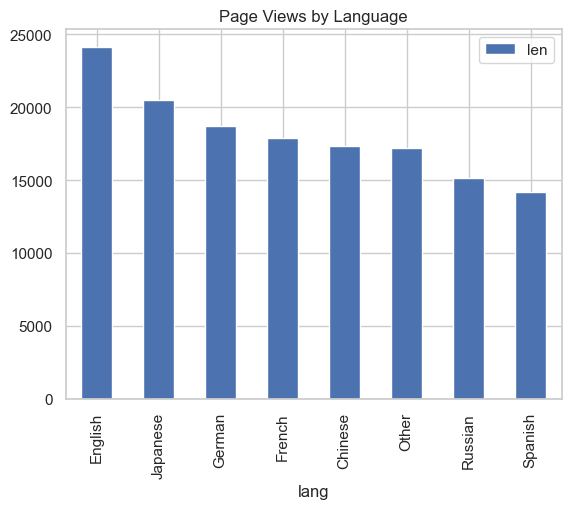

In [151]:
plt.figure(figsize=(10, 8))
cleaned_df.group_by("lang").len().sort("len", descending=True).to_pandas().plot.bar(x="lang", y="len")
plt.title("Page Views by Language");

<Figure size 1000x800 with 0 Axes>

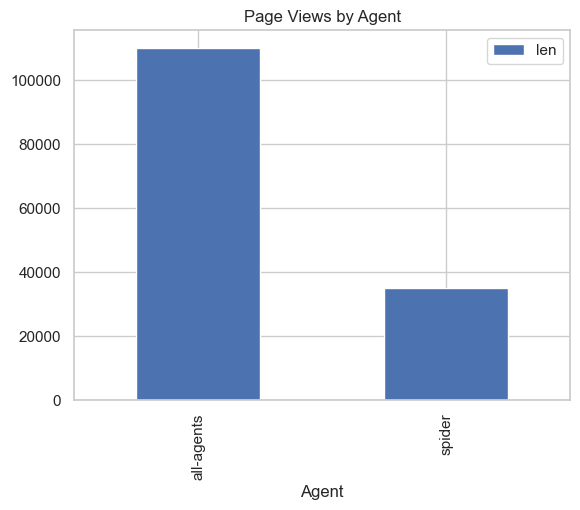

In [134]:
plt.figure(figsize=(10, 8))
cleaned_df.group_by("Agent").len().sort("len", descending=True).to_pandas().plot.bar(x="Agent", y="len")
plt.title("Page Views by Agent");

<Figure size 1000x800 with 0 Axes>

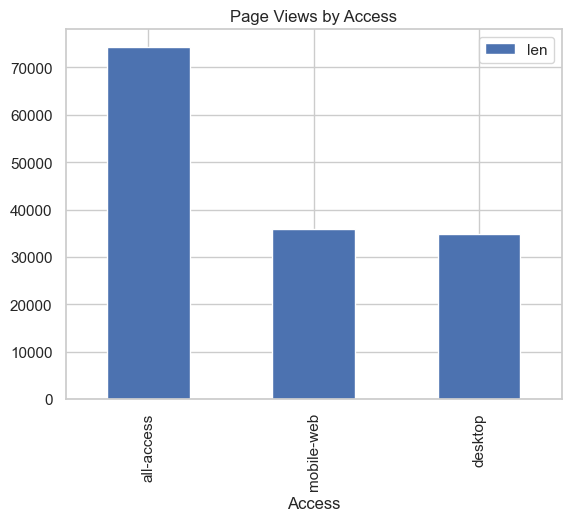

In [135]:
plt.figure(figsize=(10, 8))
cleaned_df.group_by("Access").len().sort("len", descending=True).to_pandas().plot.bar(x="Access", y="len")
plt.title("Page Views by Access");

In [172]:
lang_grp = cleaned_df.group_by("lang").sum().drop("Agent", "Access")
lang_grp

lang,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,…,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
"""Other""",1477069,1548788,1464346,1249447,1385036,1586847,1679560,1755740,1530950,1547281,1165601,1205769,1411866,1588920,1683736,1616798,1773096,1595188,1468167,1465313,1816109,1955677,1715826,1622922,1479605,1408964,1782903,1683857,1797760,1715689,2892519,1680268,3061505,1670193,1962956,2007787,…,2041914,2158720,2142316,2520928,4157704,2448214,2377015,2323118,2623705,2827612,2822307,2646563,2606370,2542841,4827018,3734861,2859781,2870442,2476462,2624603,2541253,2441475,3081714,2989461,2613503,3027418,3680641,2336215,2931946,2491251,2913440,2947931,2615280,3316427,2620026,2921474,2559123
"""Spanish""",15279998,14602449,13428998,12607803,13711974,15627539,15232641,14783419,14504467,13185904,11858311,13510484,15327578,16096772,15212758,14485800,13036926,11343056,12132508,14252905,14118075,14528019,13631289,12107623,10849223,11964941,13780739,13678565,13832158,13156141,11885923,10380883,11394918,11743830,14245528,14416982,…,15764081,16627421,19190118,19453791,22936644,19855124,17733972,15845342,12804503,14932115,16799286,17859750,16370034,15832607,14290479,12123873,13478694,15310505,15285661,16108308,14209518,12937405,12171378,14251871,15949043,15488294,15145135,13839162,13157437,12386080,12714491,16820407,15946677,16578967,15648438,11562101,11079339
"""Japanese""",11864936,13622479,12307000,15457627,14828618,12922630,12570816,12494311,12179762,12654331,13068243,14059069,12517398,11727093,11752028,13443986,16093387,13532831,13269906,13273637,11599116,11638257,11057718,10060492,9804823,10497848,10145374,9917127,10798926,9743033,9130774,8862972,9887186,10682450,12344808,12153812,…,15376787,15989146,17342398,14386738,16345439,13601936,16271026,15232048,15870467,17509081,15325843,14397142,17702667,15595682,16881040,16319927,17469249,15946503,15250668,16605887,13999336,13786593,15686739,19008466,15993510,16059254,14547788,13794046,19778445,17502241,16721058,15919063,16124459,16152145,17683587,19452390,24461932
"""English""",84712323,84438676,80167807,83463351,86198774,92809569,87838163,82880435,84799344,84319604,84789202,93279023,92392052,92916294,85897549,86911252,83306009,80407700,85355858,89703719,85445610,84101862,82835476,80528880,80688971,86443149,87839162,86547291,100997970,79149920,76561432,76695026,83480508,78772328,84914381,85031471,…,107788266,121988297,127491196,116790779,120243129,112338727,111159612,109467860,123415872,124686850,127319077,126321875,119067662,116664998,108556921,113151730,117612769,121038477,115257216,121089002,110158675,103840461,103804092,120029012,130940080,128043995,118888302,120491905,112905519,119861247,123926452,139112369,145628953,141278597,150557723,125404796,123624015
"""Chinese""",4147071,4152793,4125028,4164784,4442807,4466109,4461263,4577333,4549099,4729303,4412580,4971098,4562122,4309581,4226023,4215704,4233702,4411839,4973591,4678115,4602217,4659355,4146985,3601962,3465035,3740949,3741118,3693489,3730

In [176]:
df=lang_grp.unpivot(index="lang", variable_name="dates").pivot("lang", index="dates")
df=df.with_columns(
    pl.col("dates").cast(pl.Date),
)

In [177]:
campaign_df = pl.read_csv("../data/processed/Exog_Campaign_eng.csv", has_header=True, ignore_errors=True)
campaign_df

Exog
i64
0
0
0
0
0
…
1
1
1


In [178]:
df=df.hstack(campaign_df)
df.head(10)

dates,Other,Spanish,Japanese,English,Chinese,German,Russian,French,Exog
date,i32,i32,i32,i32,i32,i32,i32,i32,i64
2015-07-01,1477069,15279998,11864936,84712323,4147071,13264635,9466267,8460177,0
2015-07-02,1548788,14602449,13622479,84438676,4152793,13084303,9630020,8514332,0
2015-07-03,1464346,13428998,12307000,80167807,4125028,12558048,8925576,8187395,0
2015-07-04,1249447,12607803,15457627,83463351,4164784,11523603,8395377,8750945,0
2015-07-05,1385036,13711974,14828618,86198774,4442807,13395805,8940768,8591590,0
2015-07-06,1586847,15627539,12922630,92809569,4466109,14746420,9631695,8951425,0
2015-07-07,1679560,15232641,12570816,87838163,4461263,14301345,9411165,8652420,0
2015-07-08,1755740,14783419,12494311,82880435,4577333,14509892,9366525,8493256,0
2015-07-09,1530950,14504467,12179762,84799344,4549099,13968844,9594537,8405132,0


In [179]:
df.write_parquet("../data/processed/df.parquet")

# EDA

In [11]:
df=pl.read_parquet("../data/processed/df.parquet").to_pandas()

In [12]:
df=df.set_index("dates")
df

,Other,Spanish,Japanese,English,Chinese,German,Russian,French,Exog
dates,,,,,,,,,
2015-07-01,1477069,15279998,11864936,84712323,4147071,13264635,9466267,8460177,0
2015-07-02,1548788,14602449,13622479,84438676,4152793,13084303,9630020,8514332,0
2015-07-03,1464346,13428998,12307000,80167807,4125028,12558048,8925576,8187395,0
2015-07-04,1249447,12607803,15457627,83463351,4164784,11523603,8395377,8750945,0
2015-07-05,1385036,13711974,14828618,86198774,4442807,13395805,8940768,8591590,0
...,...,...,...,...,...,...,...,...,...
2016-12-27,2615280,15946677,16124459,145628953,6480128,20127904,15041813,15282895,1
2016-12-28,3316427,16578967,16152145,141278597,6515403,19155875,14002376,13783146,1
2016-12-29,2620026,15648438,17683587,150557723,6044182,18450782,13480581,13401250,1


In [13]:
columns = ['Other', 'Spanish', 'Japanese', 'English', 'Chinese', 'German', 'Russian', 'French']

In [14]:
columns

['Other',
 'Spanish',
 'Japanese',
 'English',
 'Chinese',
 'German',
 'Russian',
 'French']

In [15]:
df["Exog_scaled"] = df["Exog"]*df["English"]
filtered_df = df[df["Exog_scaled"] > 0]

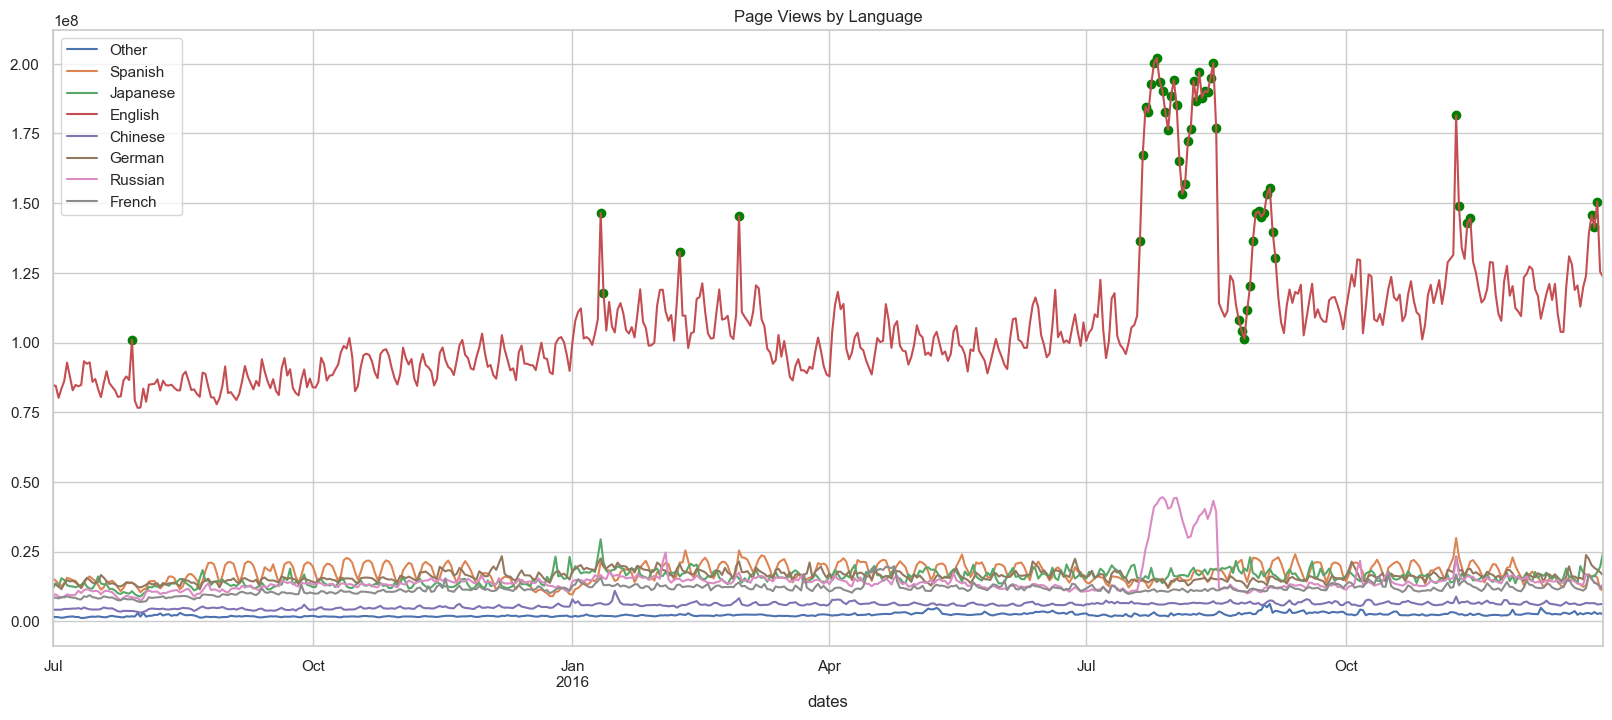

In [208]:
df.drop(["Exog","Exog_scaled"], axis=1).plot(figsize=(20, 8));
plt.scatter(filtered_df.index, filtered_df["Exog_scaled"], color="green", label="Exog_scaled")
plt.title("Page Views by Language");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that English language has highest number of page views.
- We can also see a surge in views in the month of August for English and Russian languages.
- This can be due to the campaigns run

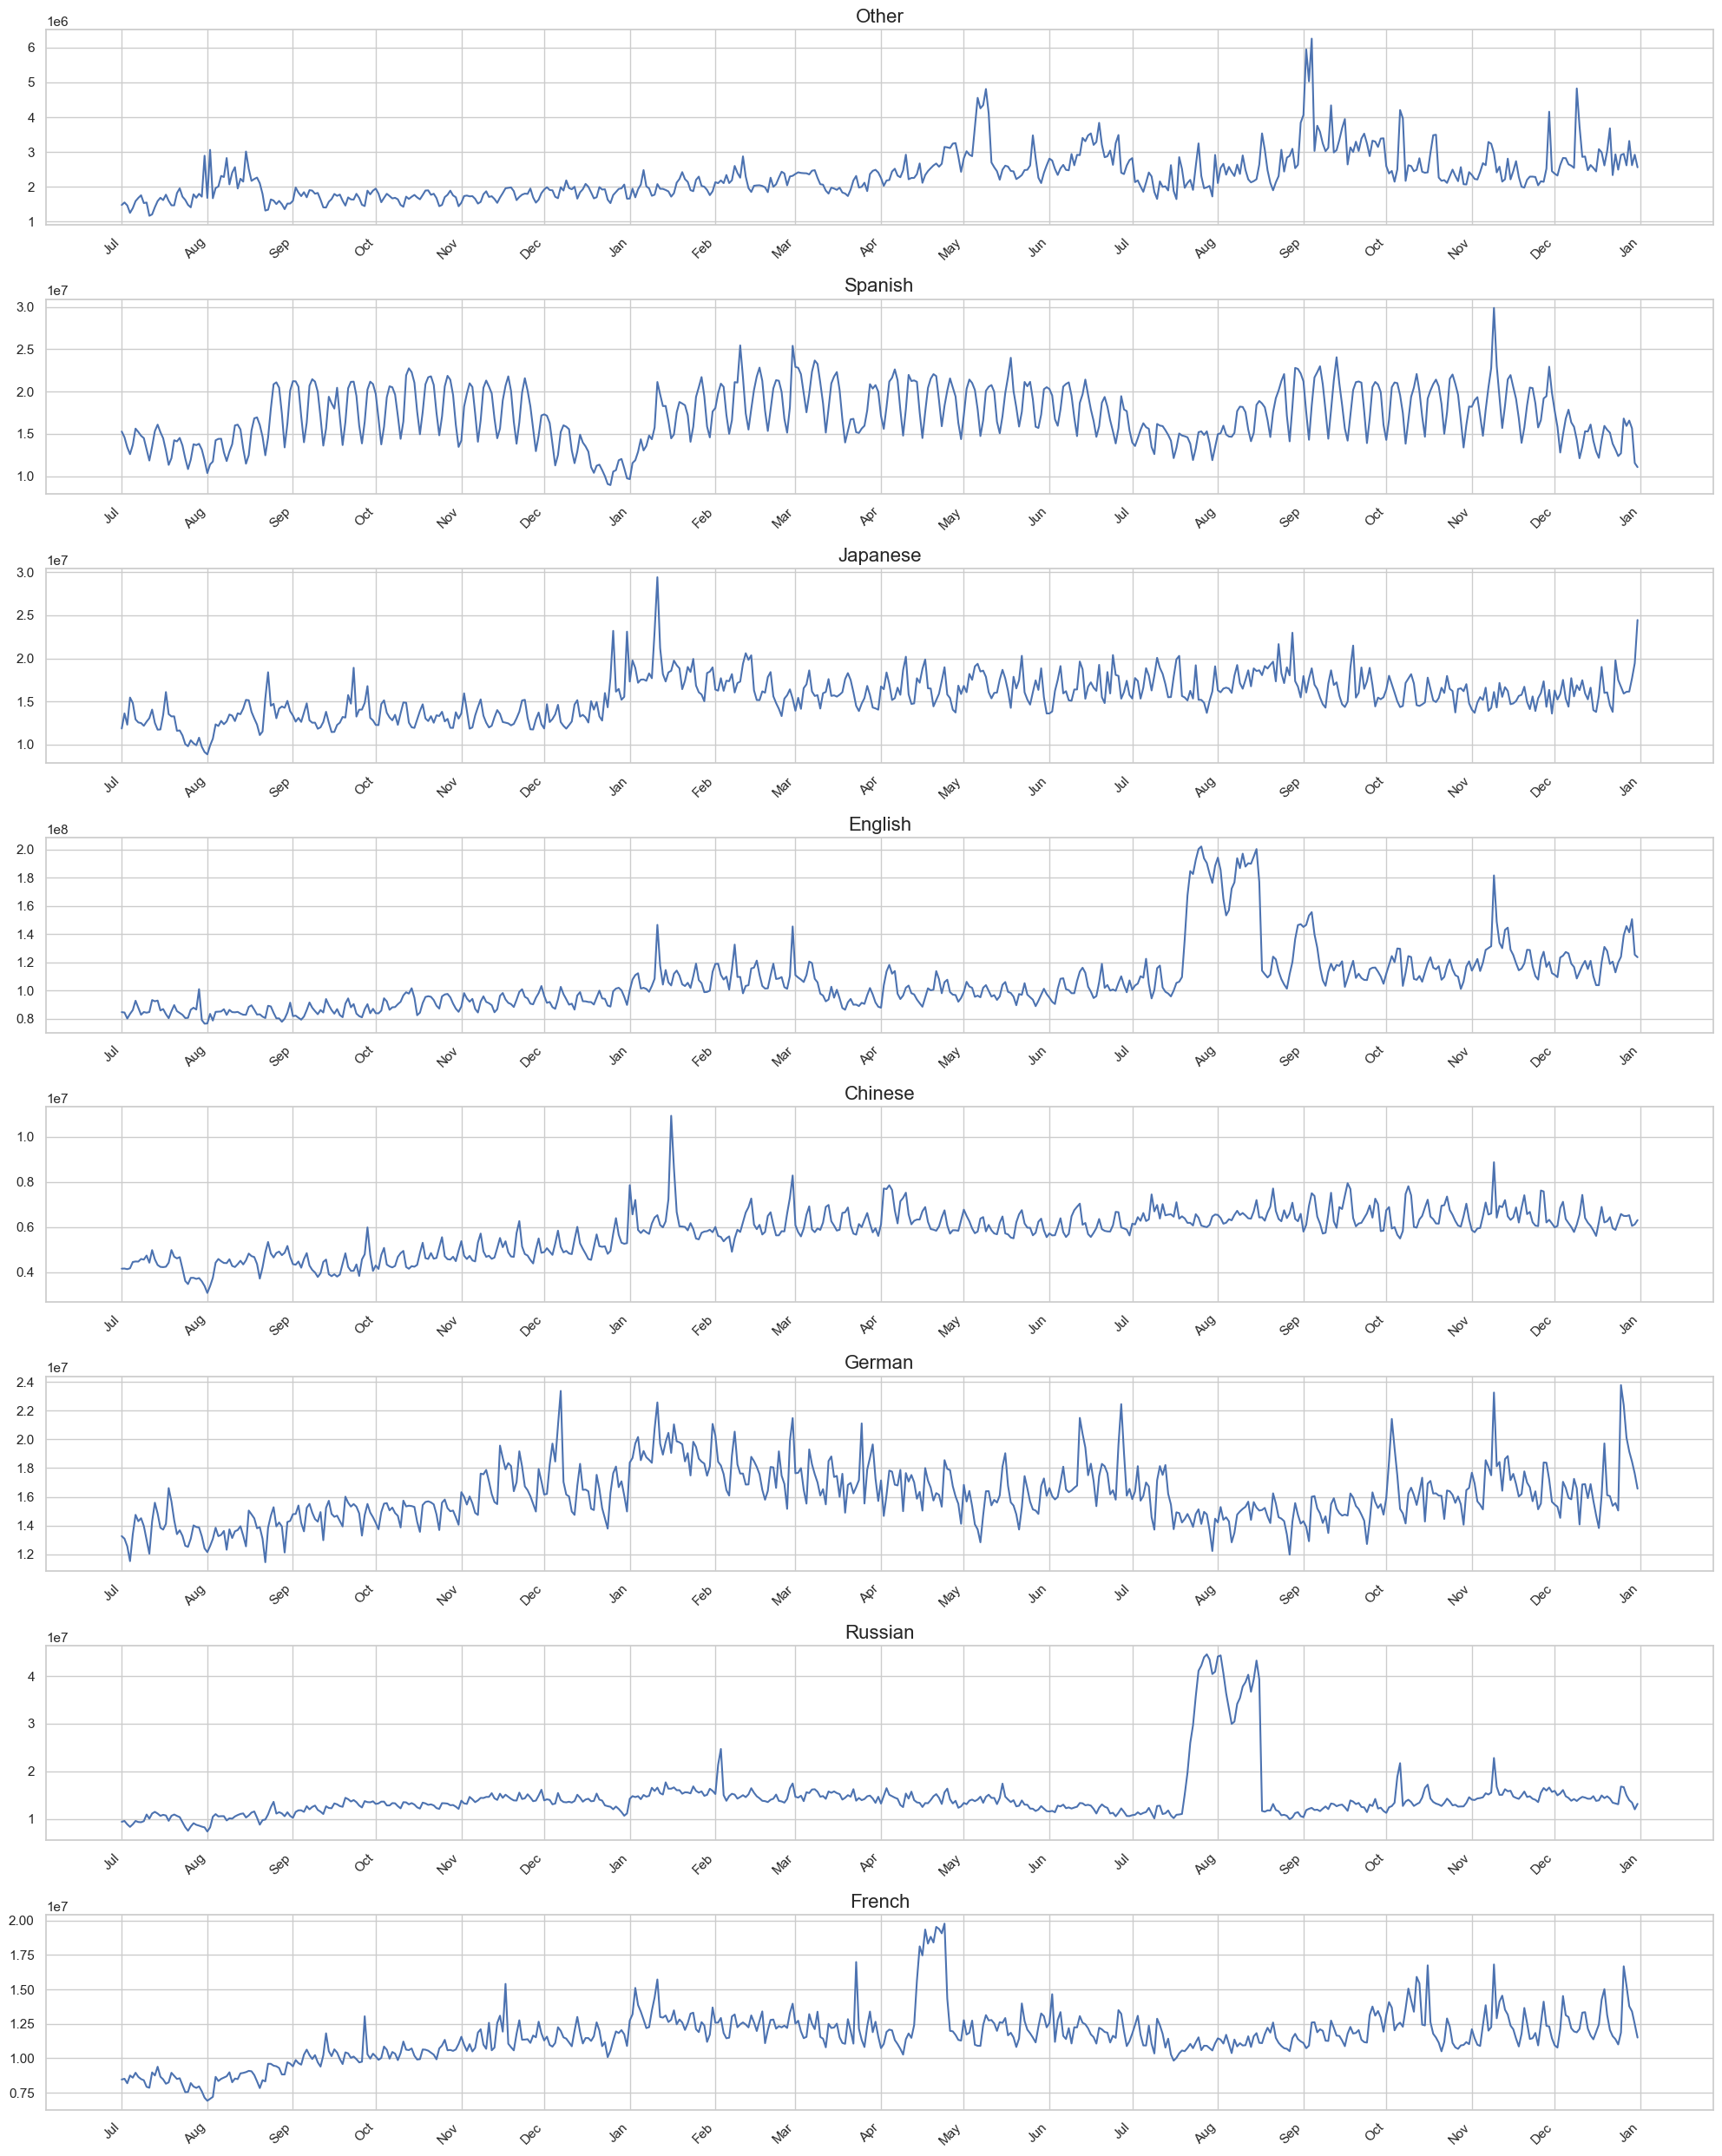

In [32]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(8, 1, figsize=(20, 25))

for i, col in enumerate(columns):
    ax[i].plot(df[col])
    ax[i].set_title(col, fontsize=16)
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

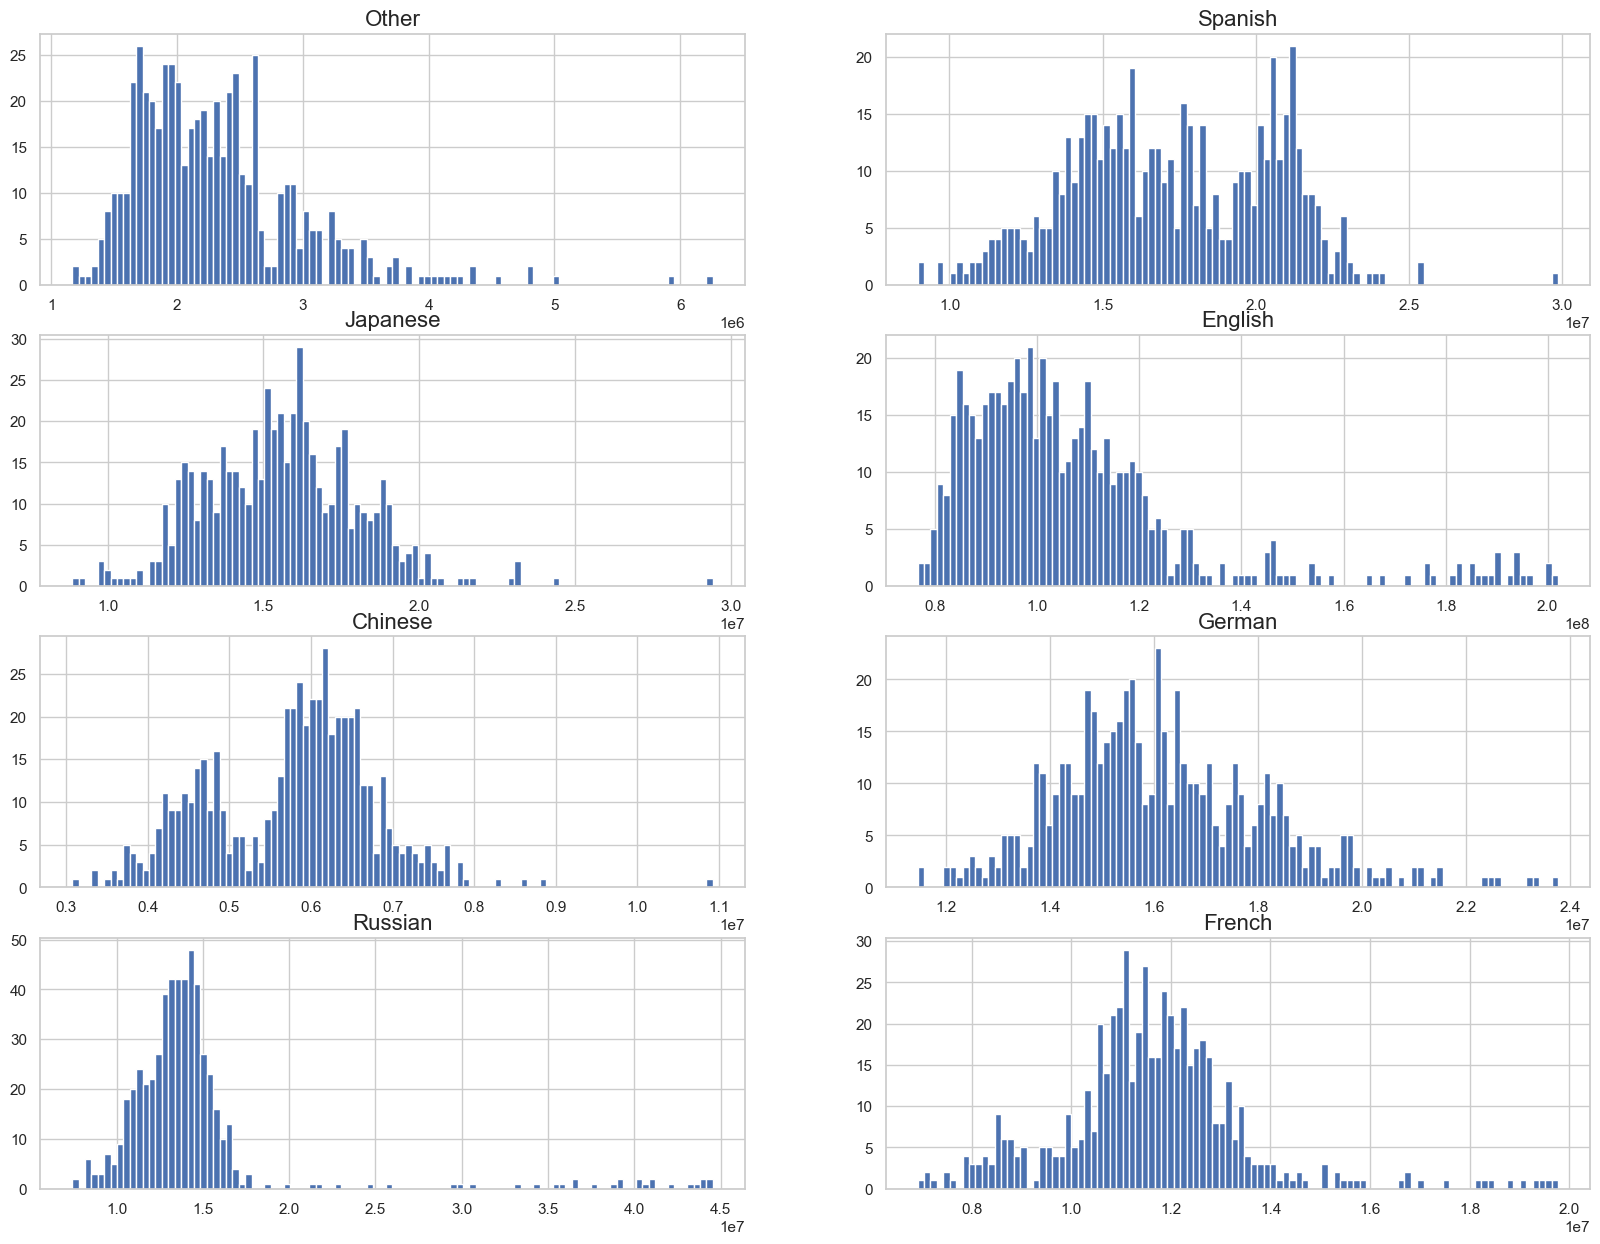

In [36]:
fig, ax = plt.subplots(4, 2, figsize=(20, 15))

for i, col in enumerate(columns):
    df[col].hist(ax=ax[i//2, i%2], bins=100)
    ax[i//2, i%2].set_title(col, fontsize=16)
# plt.tight_layout()


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see that Russian has large number of outliers

# Stationarity Check



## AD Fuller Test

In [17]:
adf_df = pd.DataFrame(columns=["Lang", "ADF Statistic", "p-value"])

for column in columns:
    result = adfuller(df[column])
    adf_df = pd.concat([adf_df, pd.DataFrame({"Lang": [column], "ADF Statistic": [result[0]], "p-value": [result[1]]})], ignore_index=True)

adf_df["is_stationary"] = adf_df["p-value"] < 0.05
adf_df.sort_values("p-value", ascending=False)

/var/folders/qz/x8fjylv90zxd4l3rz1t0vqp40000gn/T/ipykernel_2421/3530171876.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  adf_df = pd.concat([adf_df, pd.DataFrame({"Lang": [column], "ADF Statistic": [result[0]], "p-value": [result[1]]})], ignore_index=True)


,Lang,ADF Statistic,p-value,is_stationary
4,Chinese,-1.668789,0.447261,False
3,English,-2.247165,0.189574,False
5,German,-2.409148,0.139171,False
2,Japanese,-2.555357,0.102580,False
7,French,-2.849538,0.051539,False
1,Spanish,-3.014204,0.033589,True
0,Other,-3.292482,0.015218,True
6,Russian,-3.924105,0.001864,True


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

Above table shows which language time series is stationary and which is not. 

## Decomposition

**English**

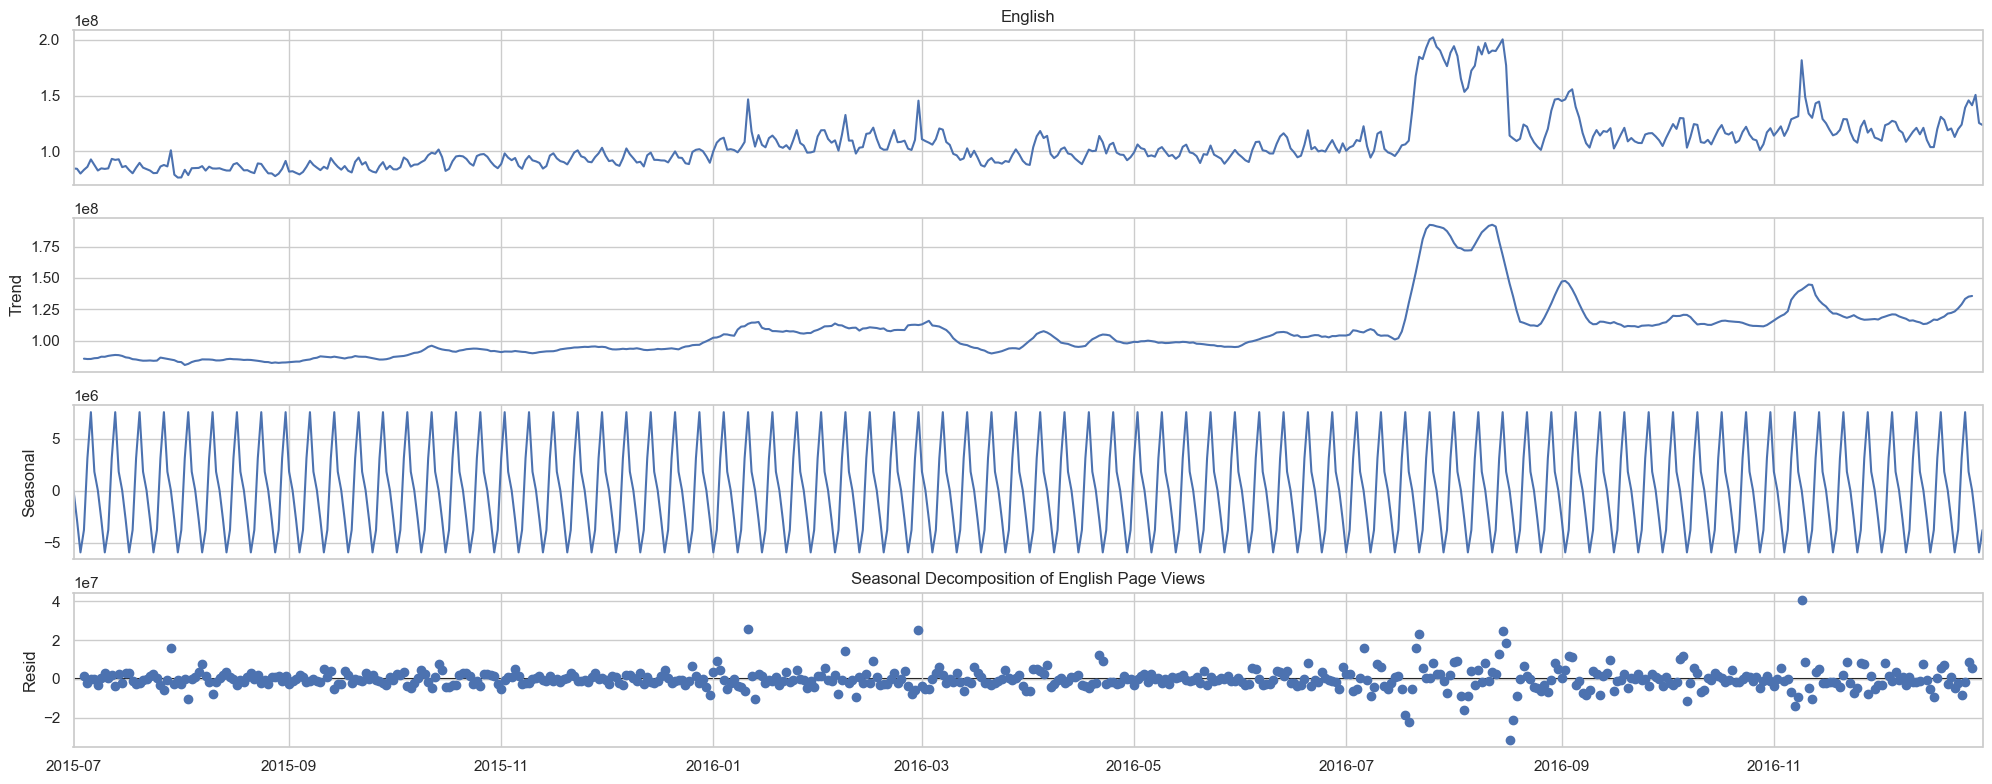

In [48]:
plt.rcParams['figure.figsize'] = (20, 8)
seasonal_decompose(df["English"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is upward trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are spread around 0 suggesting no underlying trend

**Spanish**

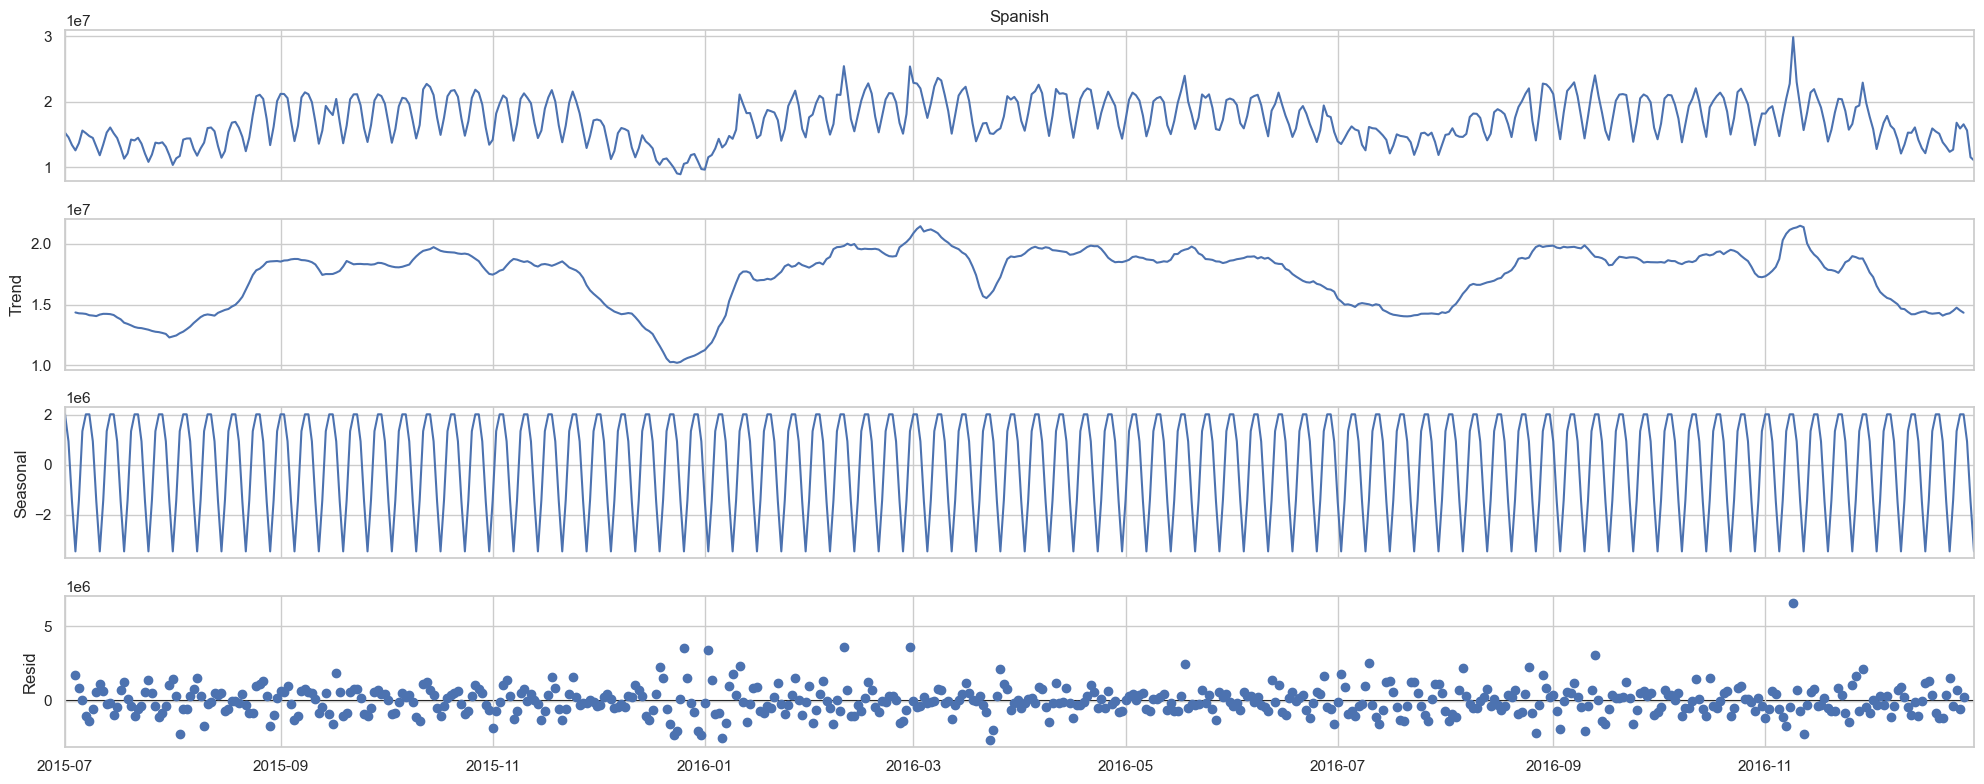

In [50]:
seasonal_decompose(df["Spanish"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is no trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are spread around 0 suggesting no underlying trend

**Russian**

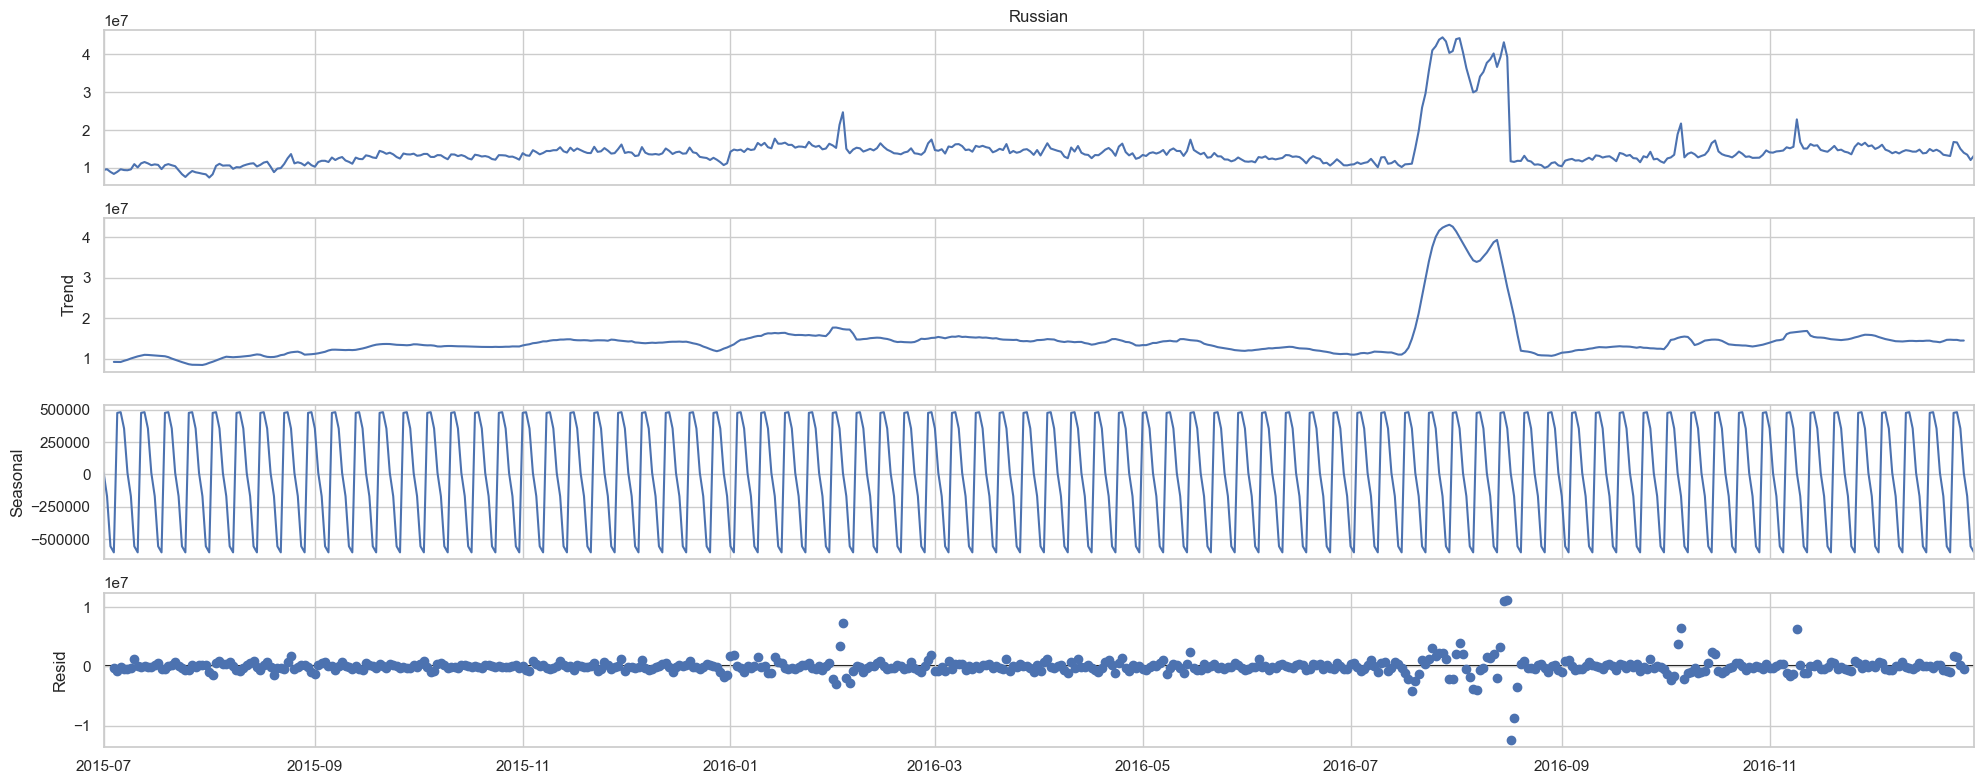

In [52]:
seasonal_decompose(df["Russian"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is small trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are tightly spread around 0 suggesting no underlying trend

**Japanese**

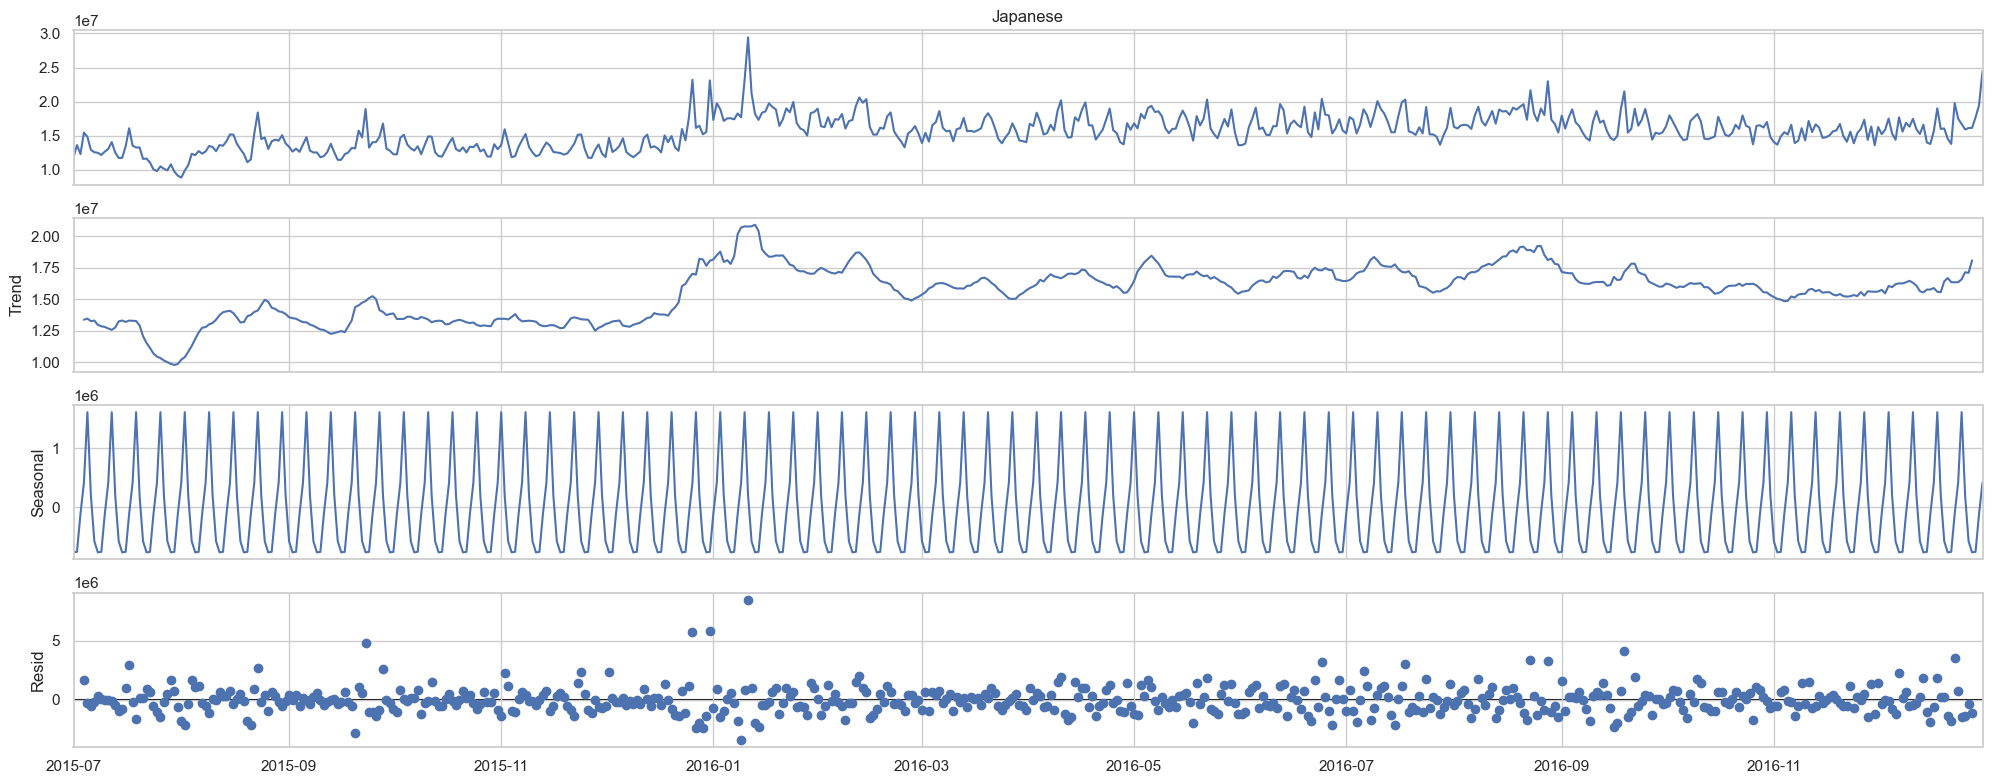

In [54]:
seasonal_decompose(df["Japanese"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there was a jump in view but then it is constant
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

**French**

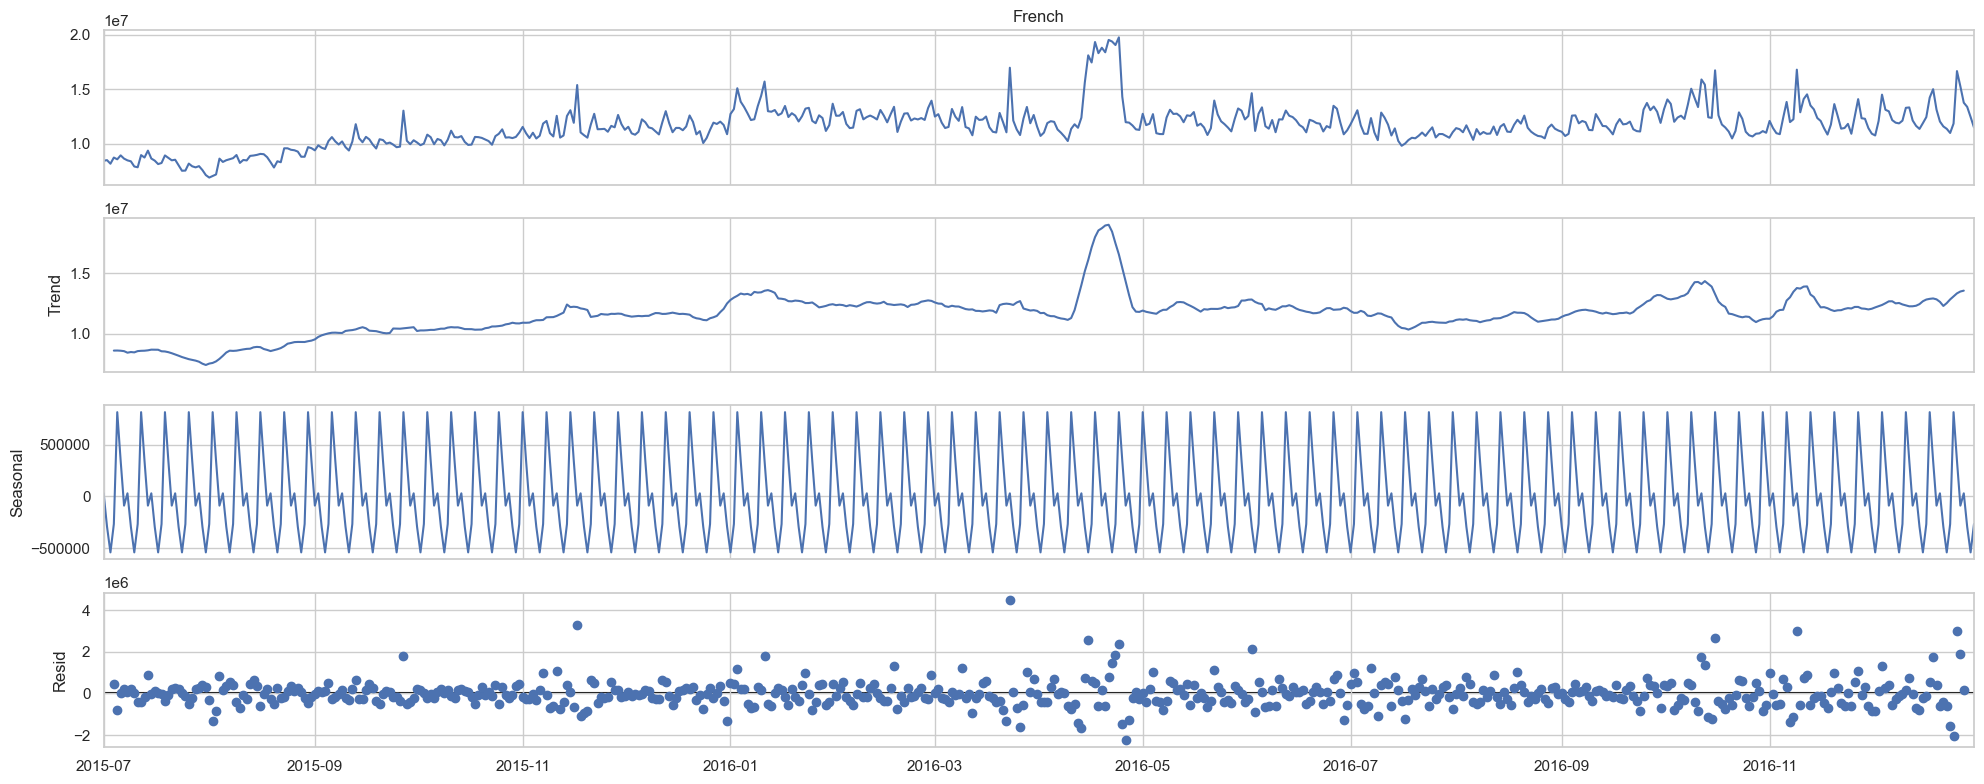

In [56]:
seasonal_decompose(df["French"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is small trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

**German**

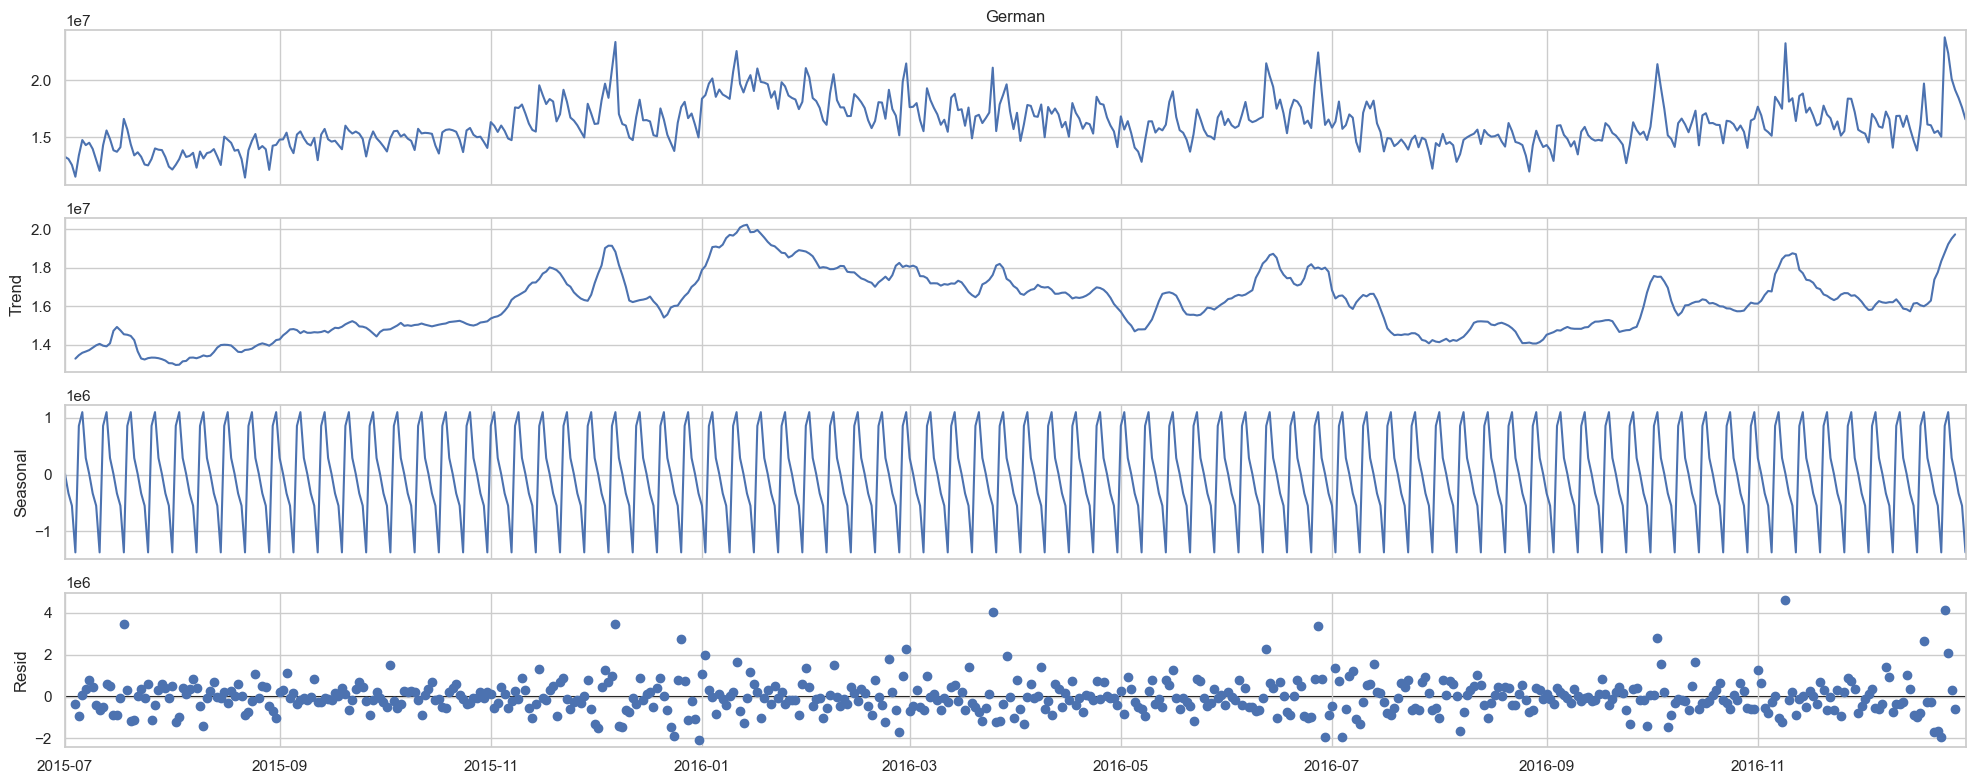

In [57]:
seasonal_decompose(df["German"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there are ups and downs in the page views count but no clear trend
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

**Chinese**

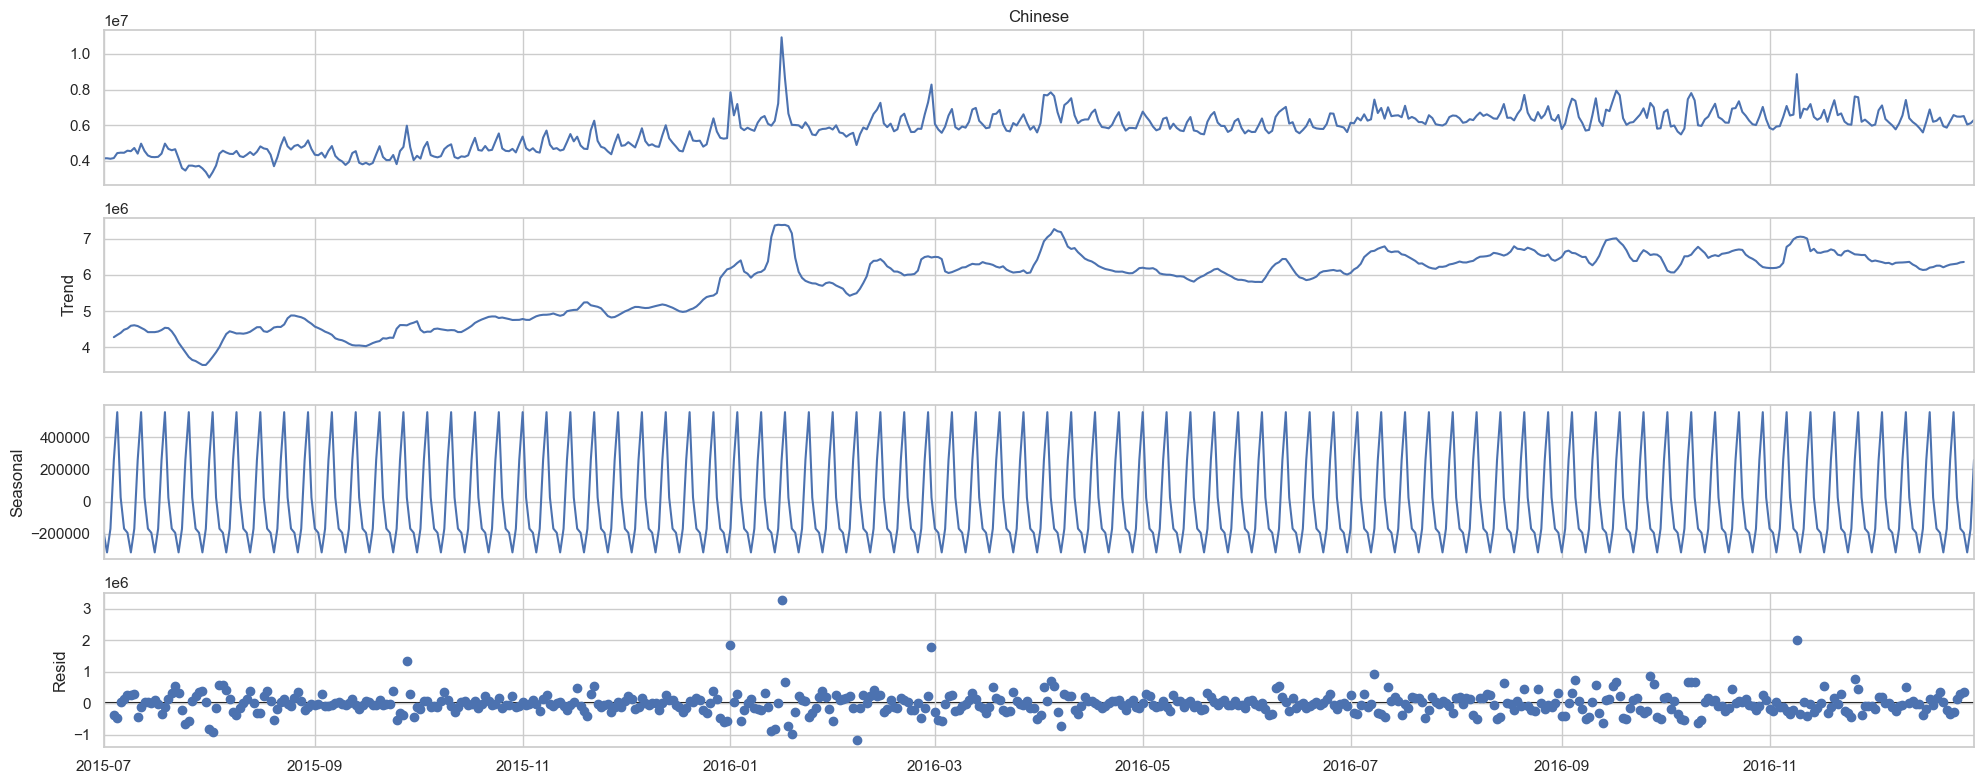

In [58]:
seasonal_decompose(df["Chinese"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there was a jump in view but then it is constant
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

# Differencing

In [16]:
df_orig = df.copy()

In [17]:
df[columns] = df[columns].diff()

In [39]:
df

,Other,Spanish,Japanese,English,Chinese,German,Russian,French,Exog
dates,,,,,,,,,
2015-07-02,71719.0,-677549.0,1757543.0,-273647.0,5722.0,-180332.0,163753.0,54155.0,0
2015-07-03,-84442.0,-1173451.0,-1315479.0,-4270869.0,-27765.0,-526255.0,-704444.0,-326937.0,0
2015-07-04,-214899.0,-821195.0,3150627.0,3295544.0,39756.0,-1034445.0,-530199.0,563550.0,0
2015-07-05,135589.0,1104171.0,-629009.0,2735423.0,278023.0,1872202.0,545391.0,-159355.0,0
2015-07-06,201811.0,1915565.0,-1905988.0,6610795.0,23302.0,1350615.0,690927.0,359835.0,0
...,...,...,...,...,...,...,...,...,...
2016-12-27,-332651.0,-873730.0,205396.0,6516584.0,-7125.0,-2254510.0,-1676938.0,-1396984.0,1
2016-12-28,701147.0,632290.0,27686.0,-4350356.0,35275.0,-972029.0,-1039437.0,-1499749.0,1
2016-12-29,-696401.0,-930529.0,1531442.0,9279126.0,-471221.0,-705093.0,-521795.0,-381896.0,1


In [19]:
df=df.drop(["Exog_scaled"], axis=1).dropna()
df

,Other,Spanish,Japanese,English,Chinese,German,Russian,French,Exog
dates,,,,,,,,,
2015-07-02,71719.0,-677549.0,1757543.0,-273647.0,5722.0,-180332.0,163753.0,54155.0,0
2015-07-03,-84442.0,-1173451.0,-1315479.0,-4270869.0,-27765.0,-526255.0,-704444.0,-326937.0,0
2015-07-04,-214899.0,-821195.0,3150627.0,3295544.0,39756.0,-1034445.0,-530199.0,563550.0,0
2015-07-05,135589.0,1104171.0,-629009.0,2735423.0,278023.0,1872202.0,545391.0,-159355.0,0
2015-07-06,201811.0,1915565.0,-1905988.0,6610795.0,23302.0,1350615.0,690927.0,359835.0,0
...,...,...,...,...,...,...,...,...,...
2016-12-27,-332651.0,-873730.0,205396.0,6516584.0,-7125.0,-2254510.0,-1676938.0,-1396984.0,1
2016-12-28,701147.0,632290.0,27686.0,-4350356.0,35275.0,-972029.0,-1039437.0,-1499749.0,1
2016-12-29,-696401.0,-930529.0,1531442.0,9279126.0,-471221.0,-705093.0,-521795.0,-381896.0,1


# ACF and PACF

**English**

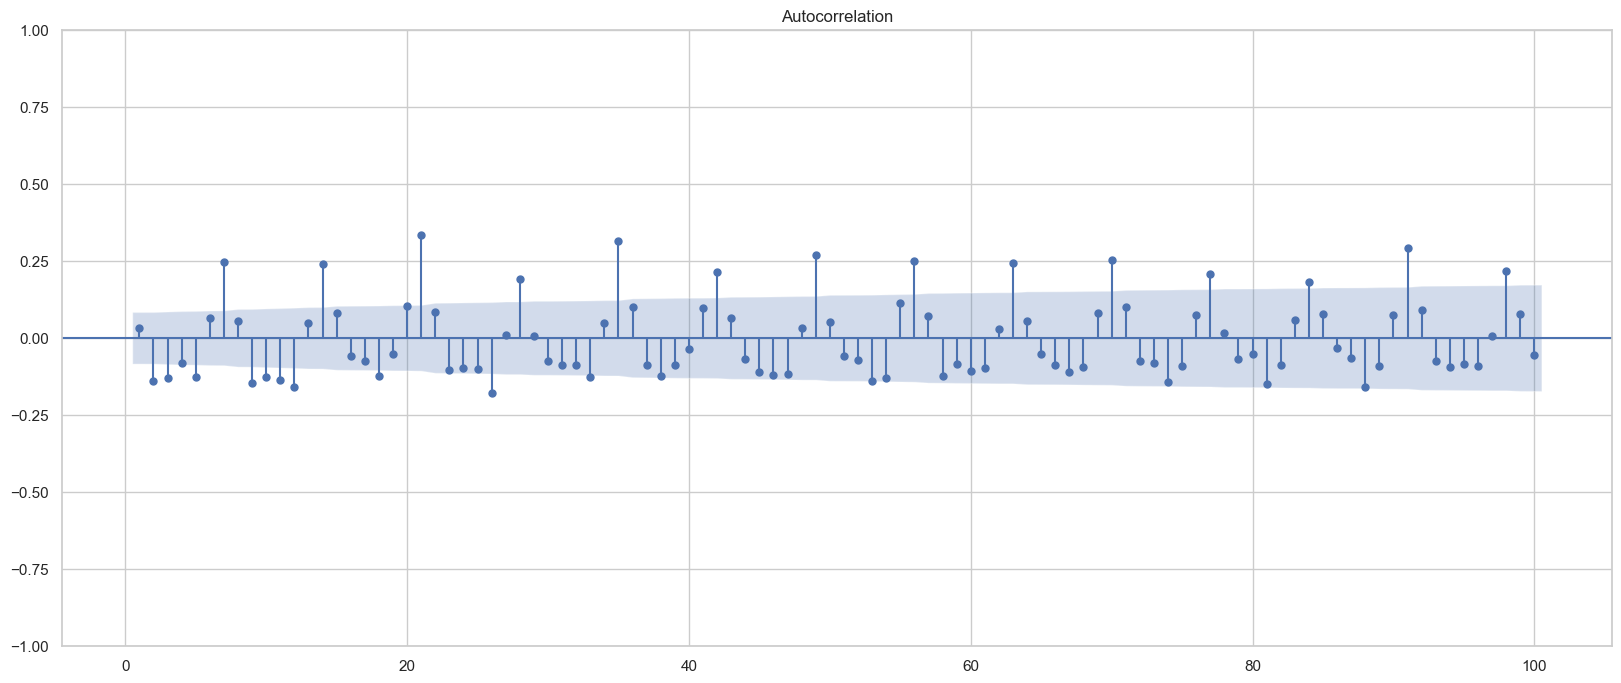

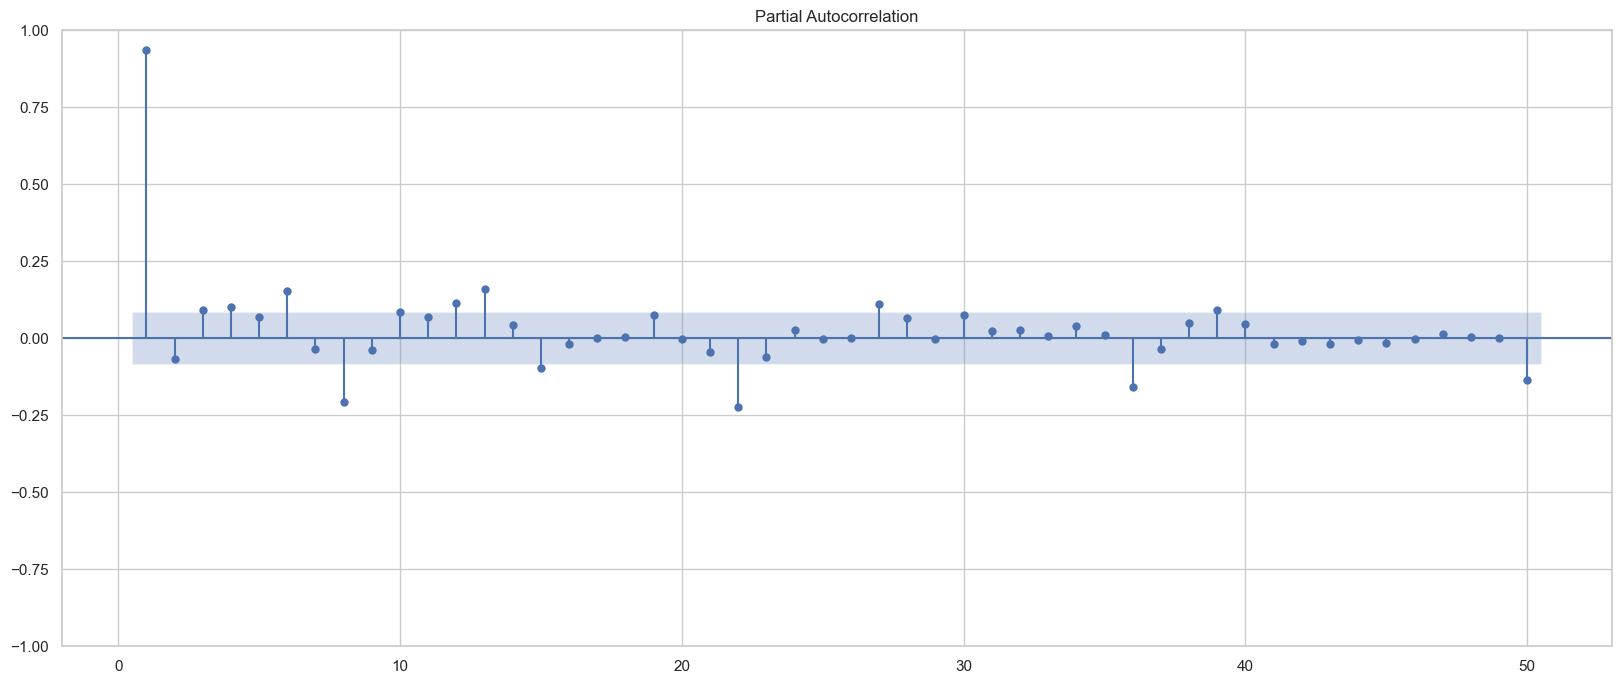

In [40]:
plt.rcParams['figure.figsize'] = (20, 8)
plot_acf(df["English"], lags=100, zero=False);
plot_pacf(df_orig["English"], lags=50, zero=False);

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>



**Spanish**

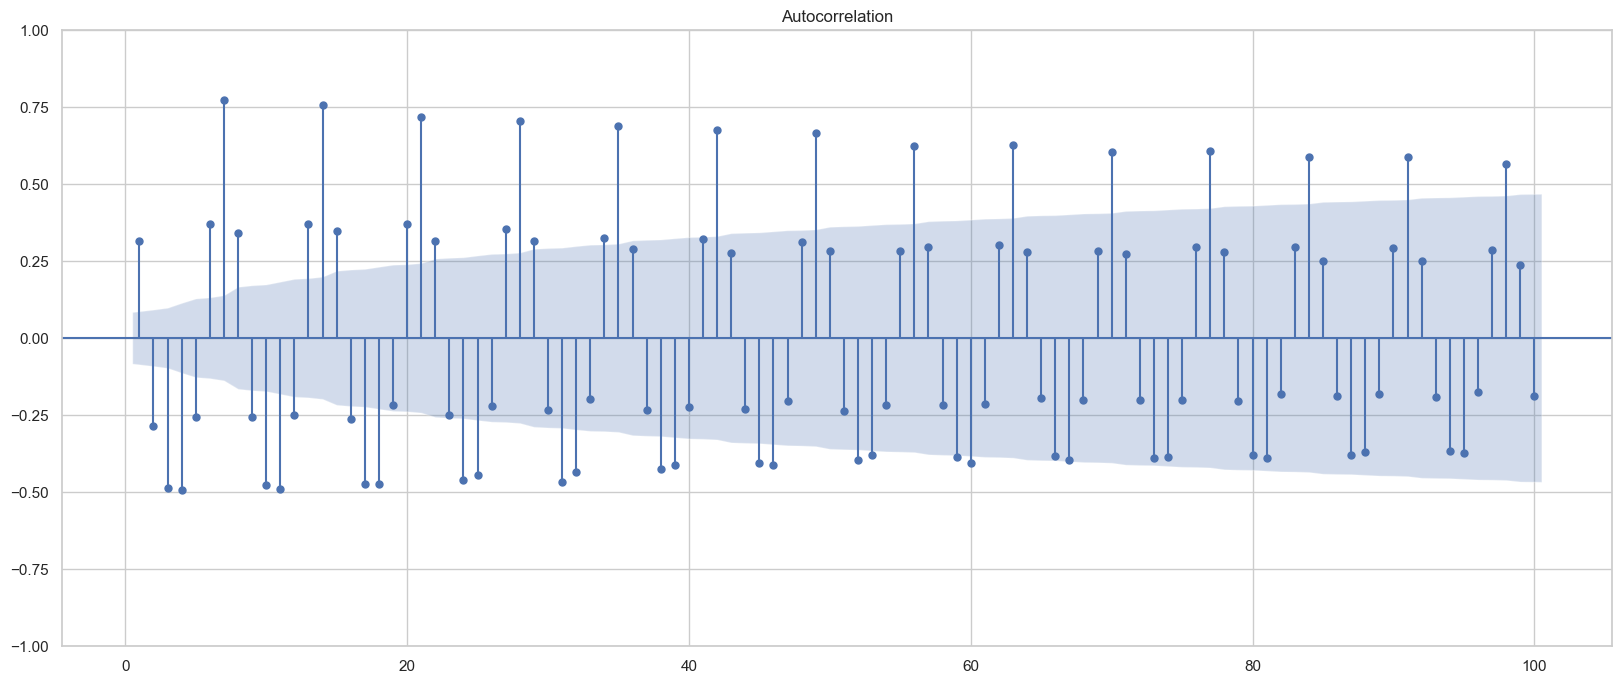

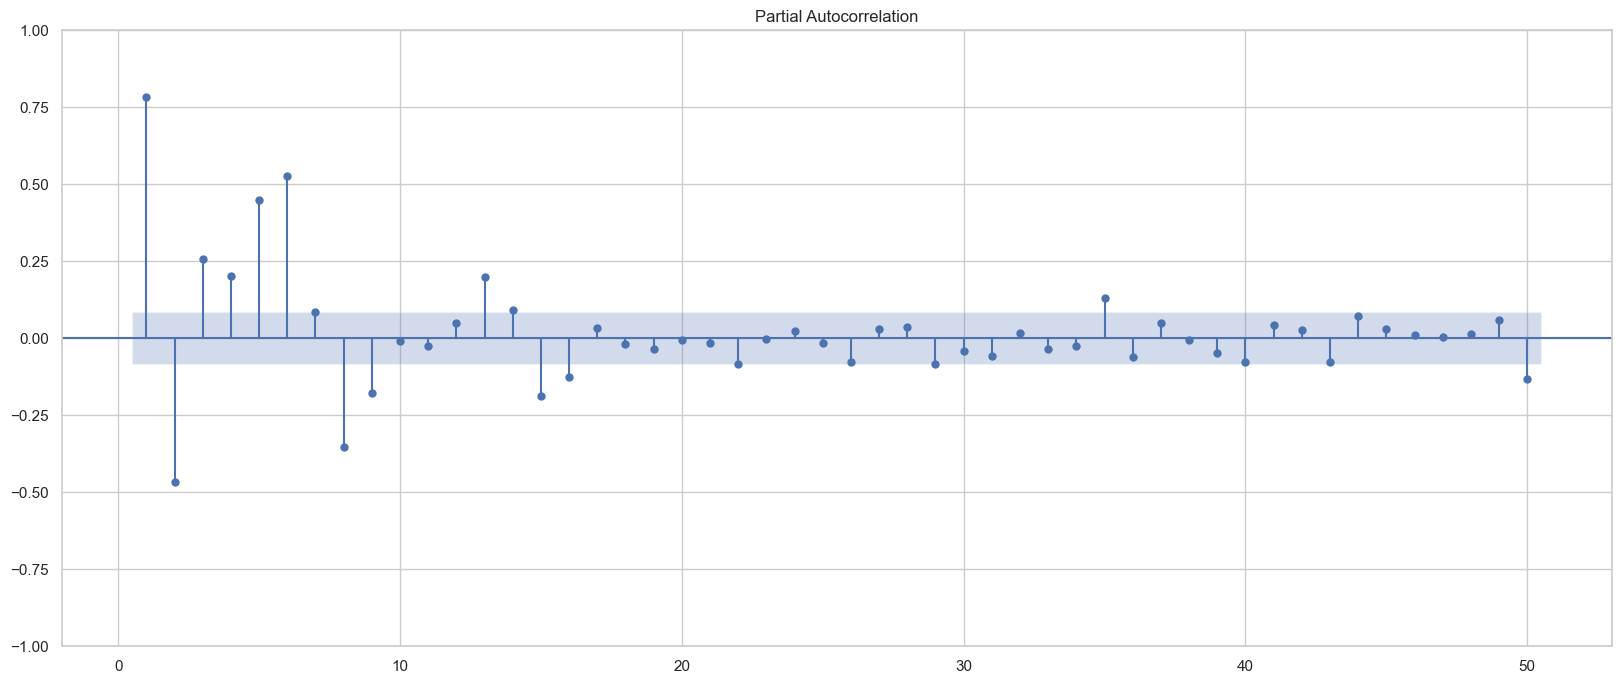

In [41]:
plot_acf(df["Spanish"], lags=100, zero=False);
plot_pacf(df_orig["Spanish"], lags=50, zero=False);

**Russian**

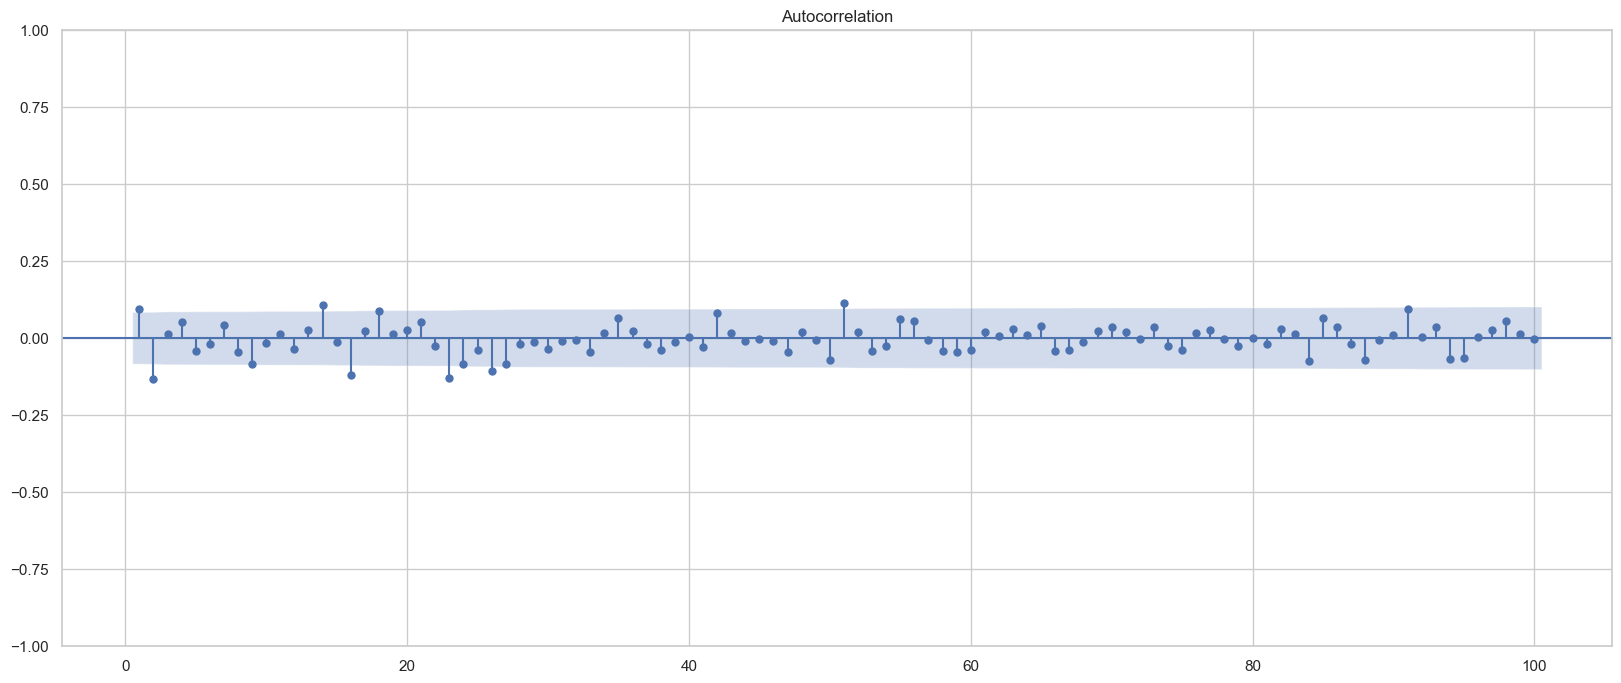

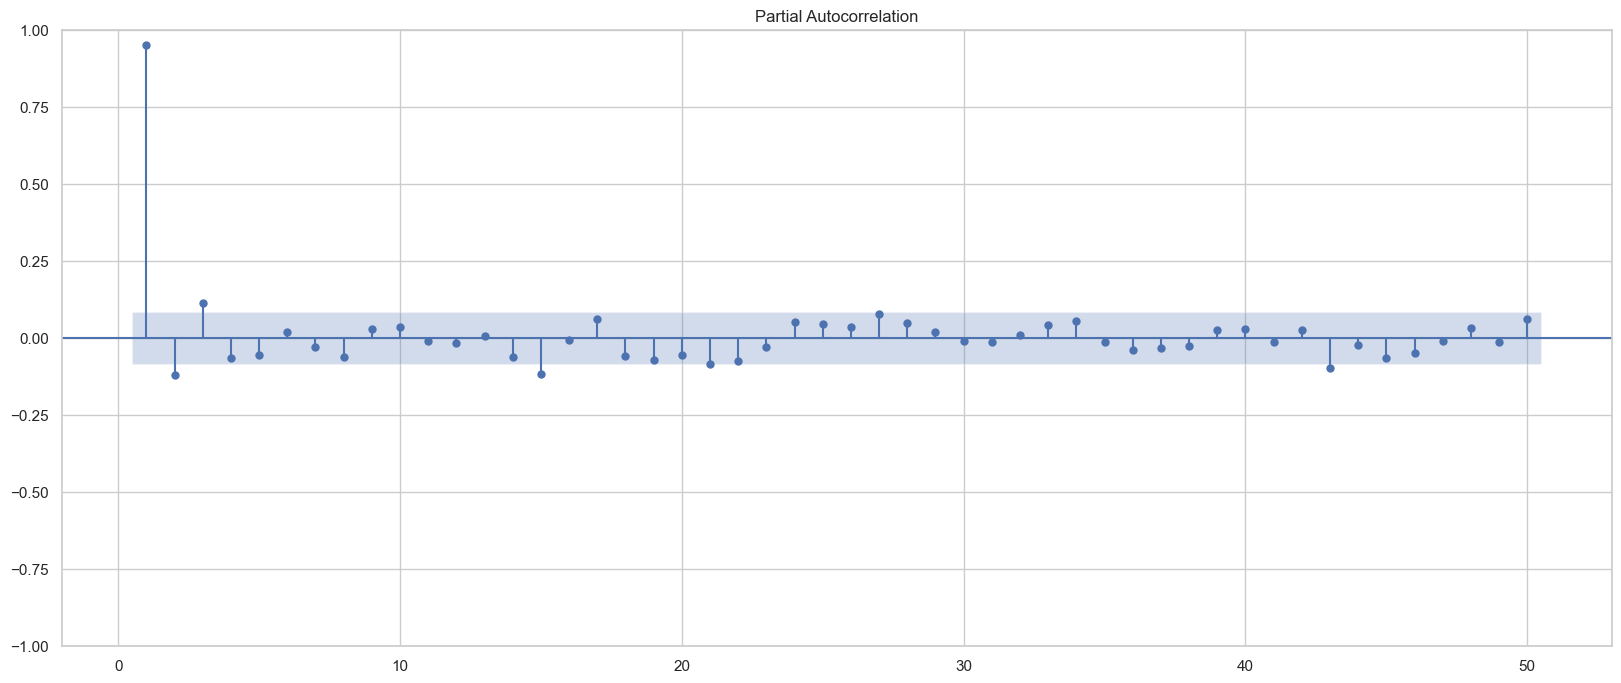

In [42]:
plot_acf(df["Russian"], lags=100, zero=False);
plot_pacf(df_orig["Russian"], lags=50, zero=False);


**Japanese**


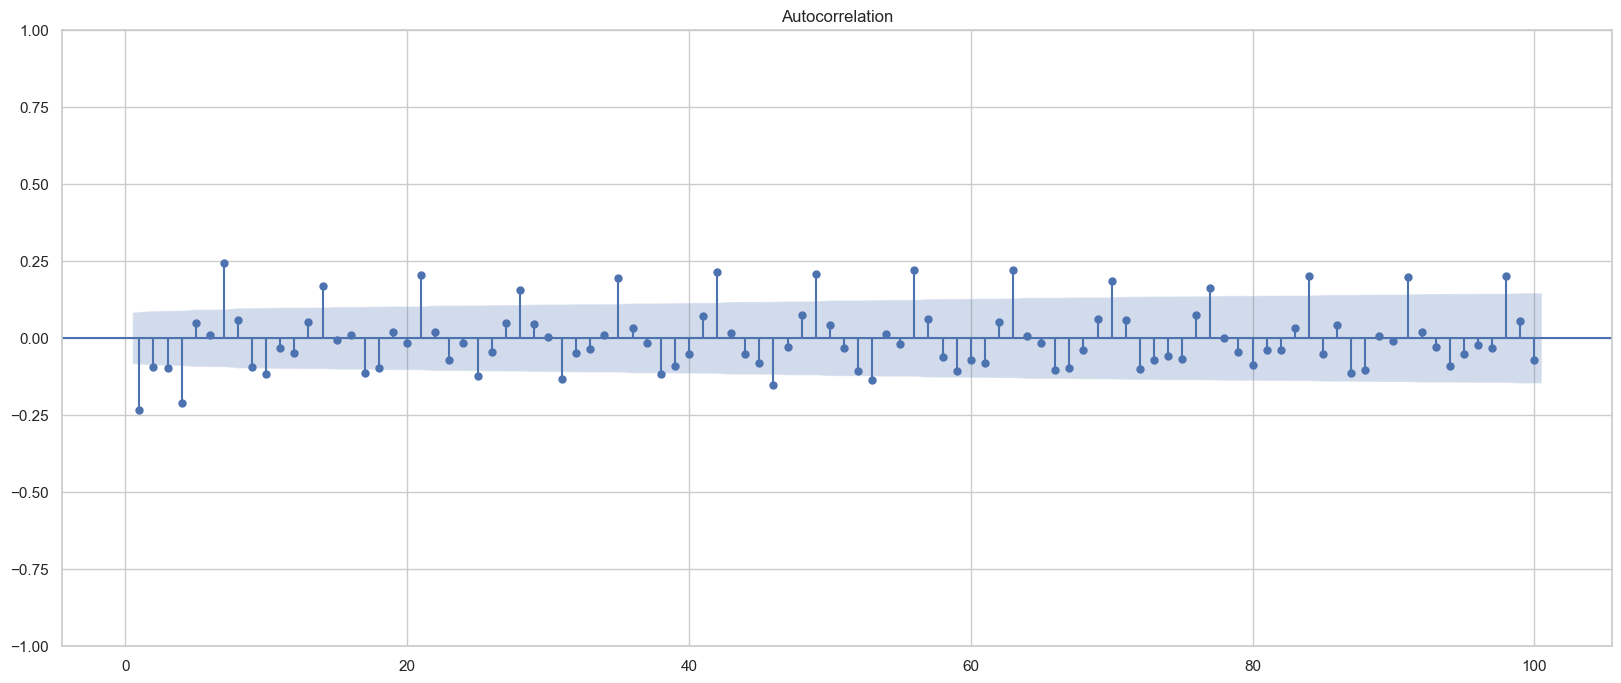

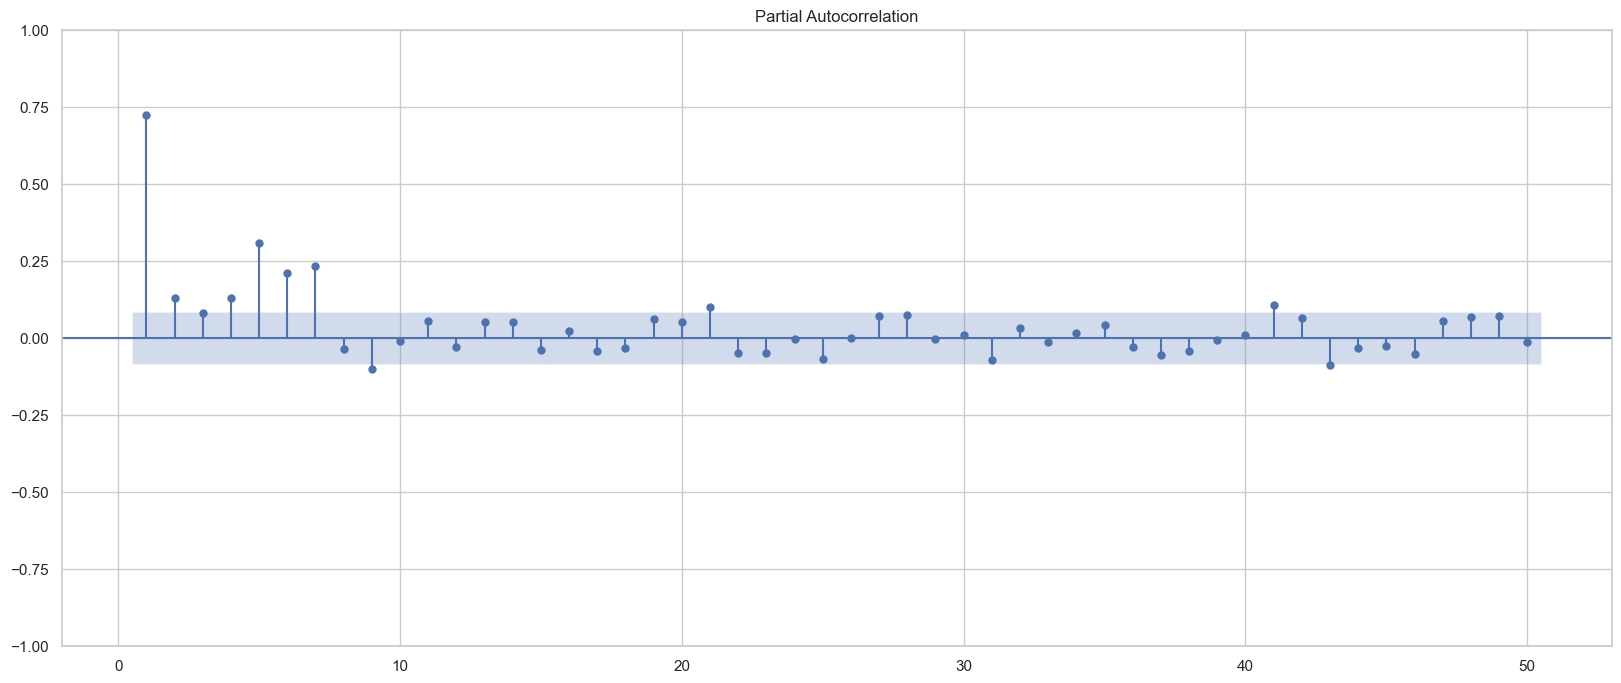

In [43]:
plot_acf(df["Japanese"], lags=100, zero=False);
plot_pacf(df_orig["Japanese"], lags=50, zero=False);


**French**


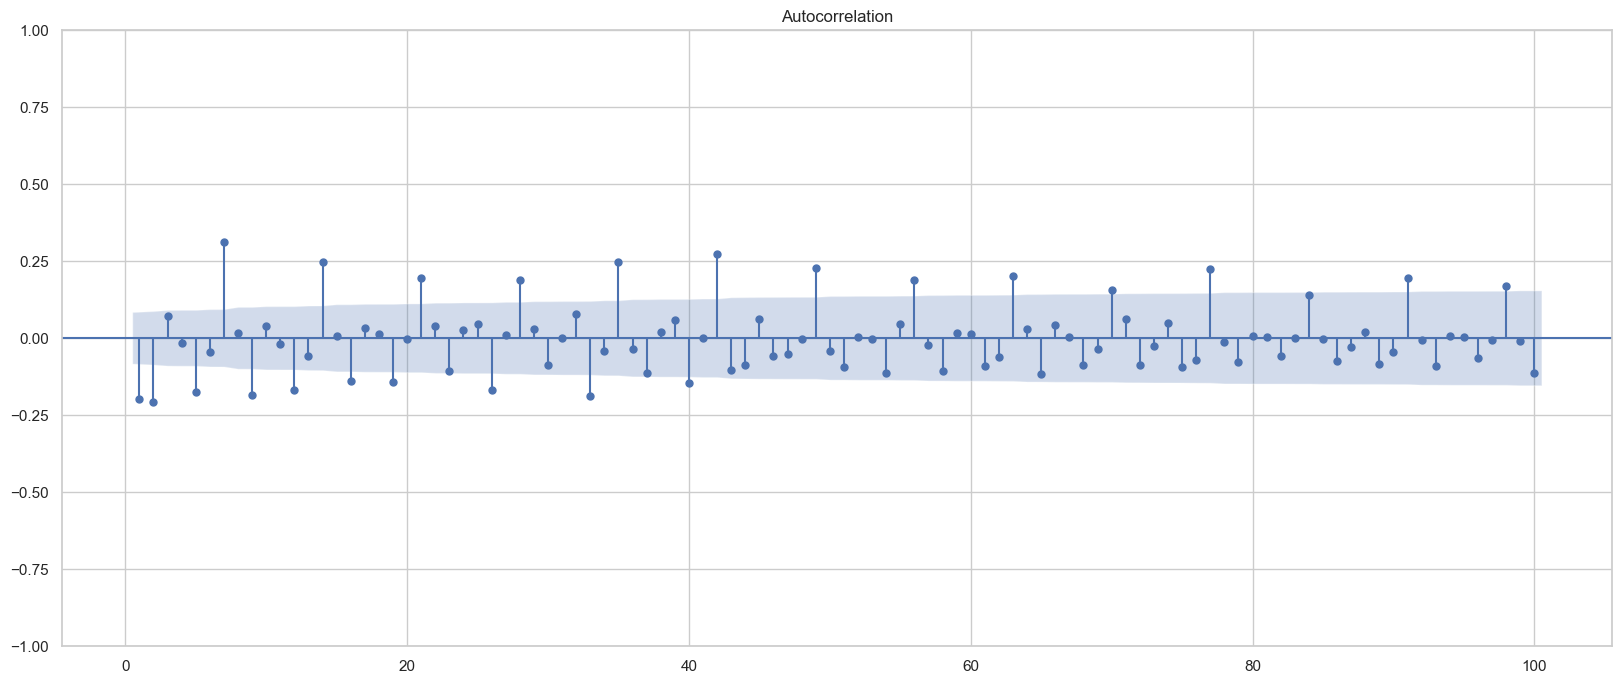

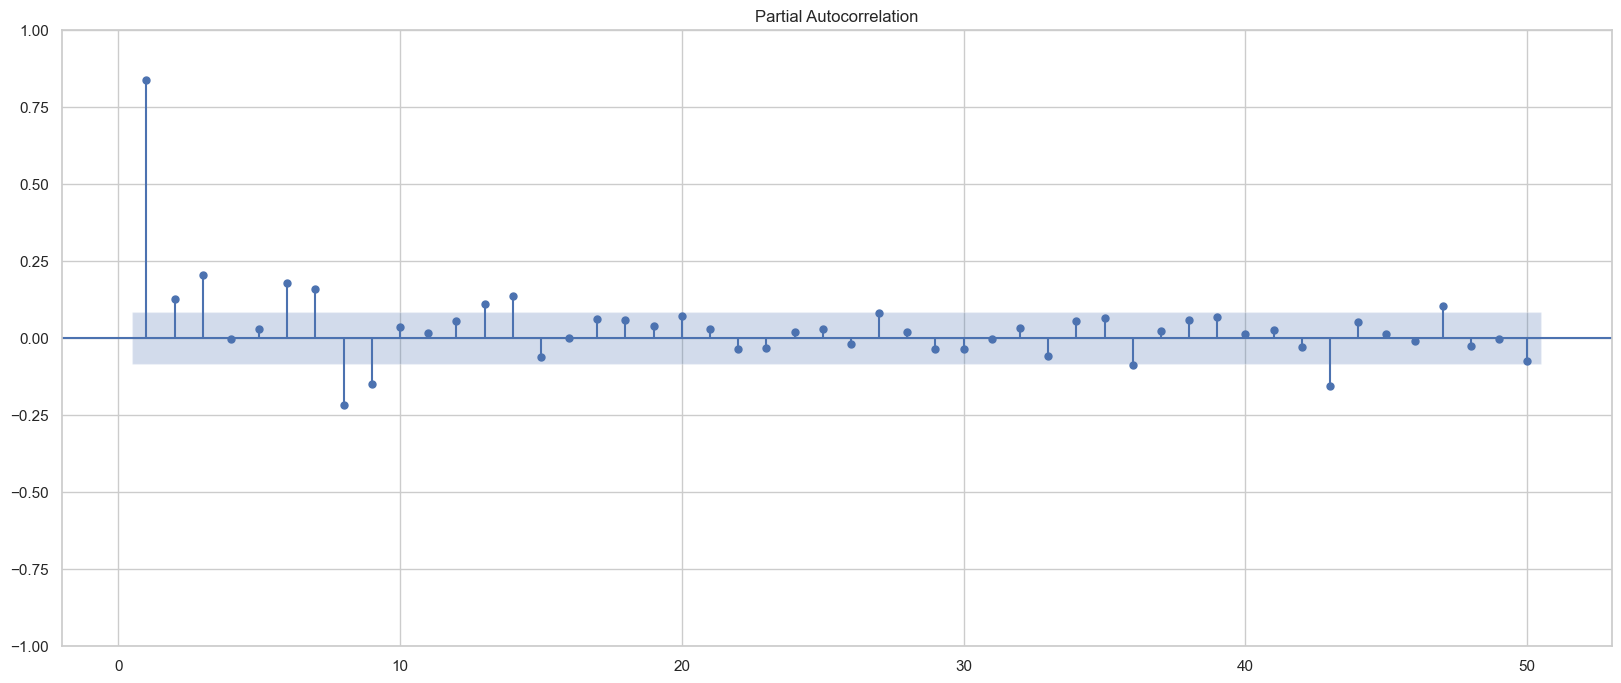

In [44]:
plot_acf(df["French"], lags=100, zero=False);
plot_pacf(df_orig["French"], lags=50, zero=False);

**German**

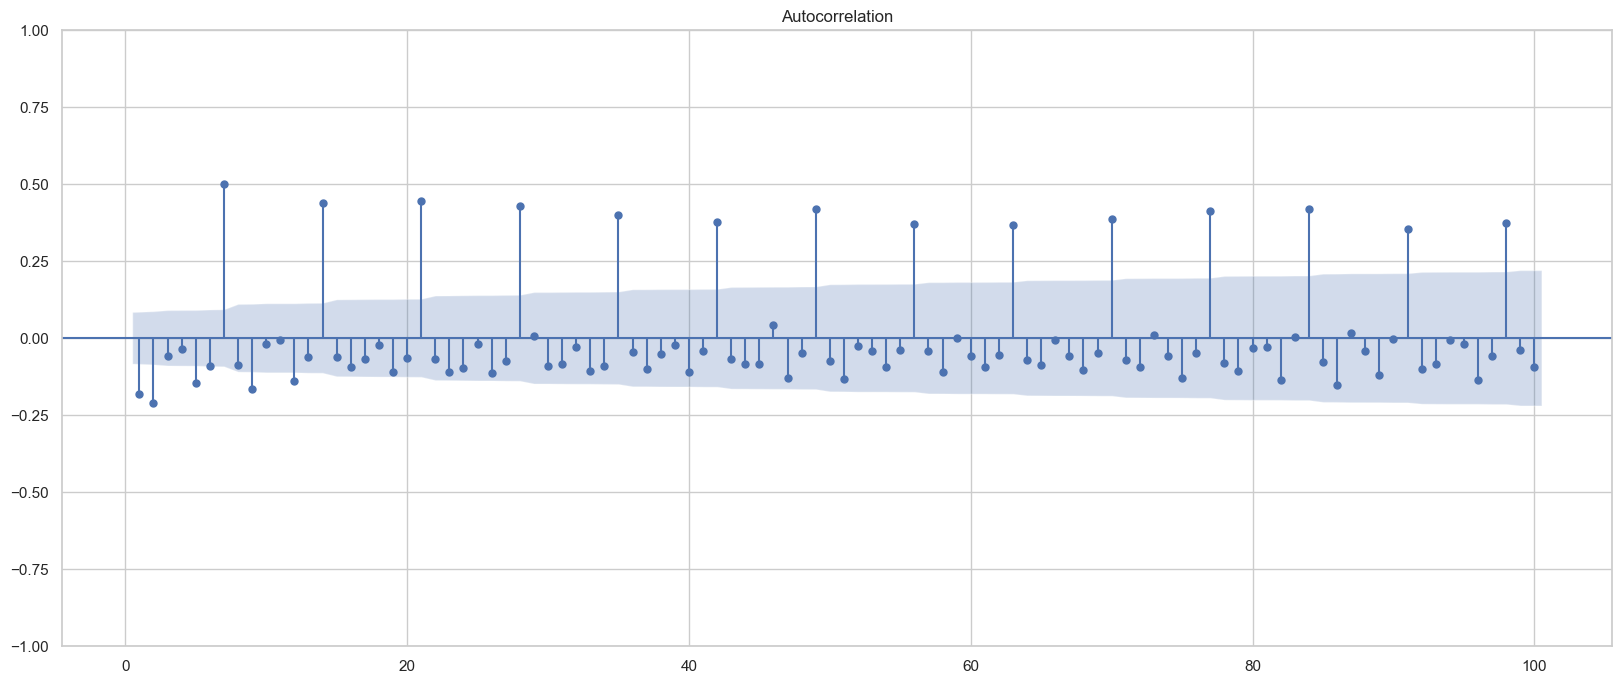

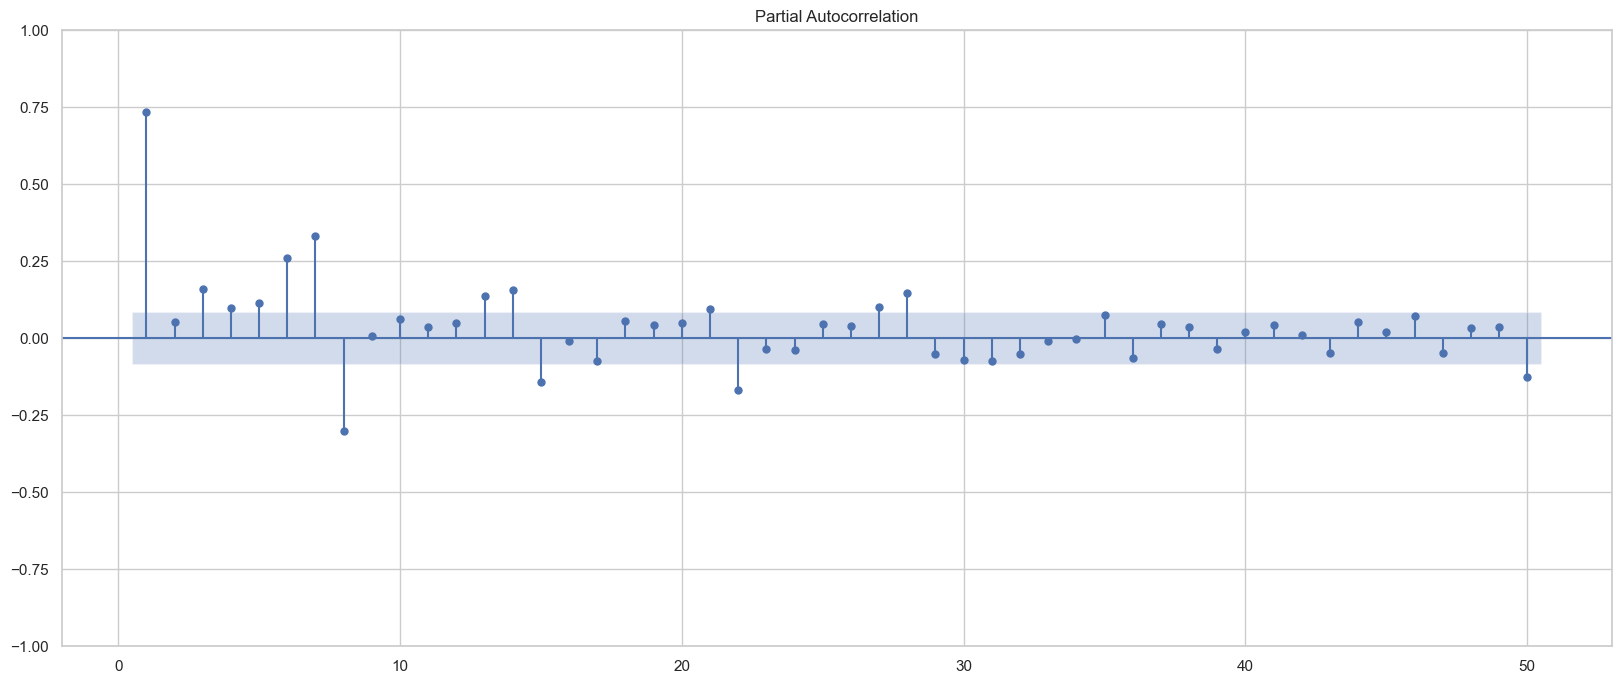

In [45]:
plot_acf(df["German"], lags=100, zero=False);
plot_pacf(df_orig["German"], lags=50, zero=False);


**Chinese**


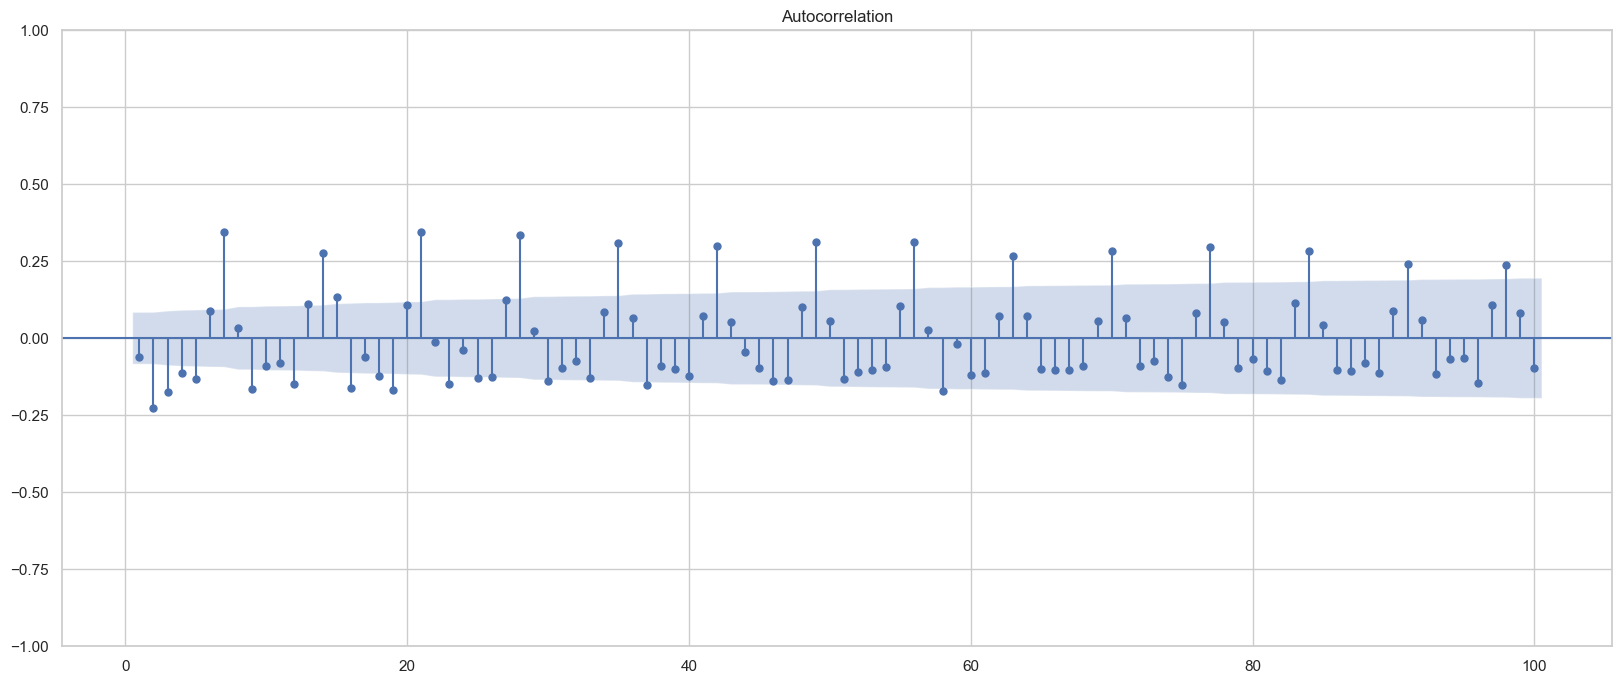

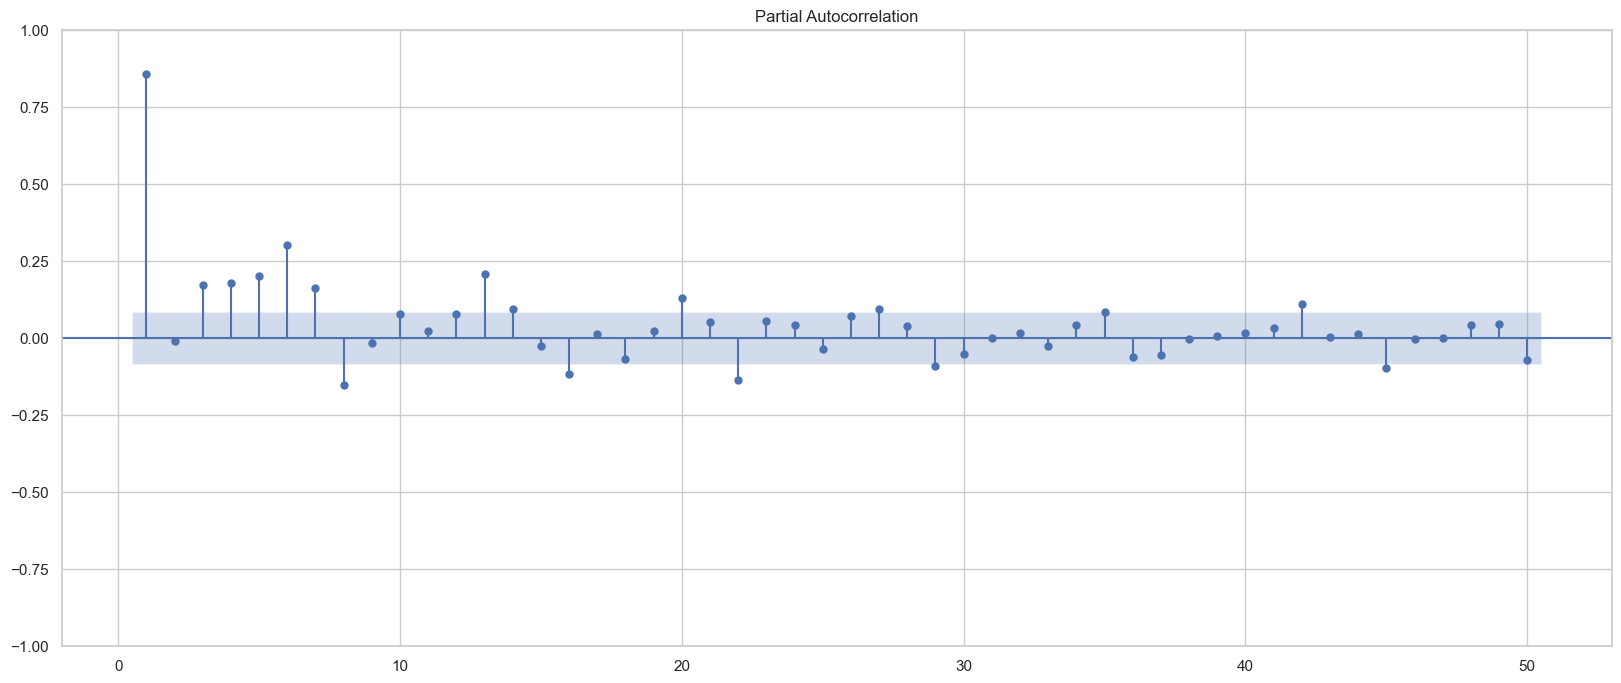

In [46]:
plot_acf(df["Chinese"], lags=100, zero=False);
plot_pacf(df_orig["Chinese"], lags=50, zero=False);